In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code."></form>''')

In [2]:
import dill
dill.load_session("Pixel_Value_With_AQE_Baseline.db")

In [3]:
# import numpy as np 
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#AQE CONSTANTS
M_VALUES = [1,2,3,4,5,6]

#IMAGE SIZE CONSTANTS
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
TOTAL_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT

#DATASET CONSTANTS
DATASET = "MPEG7"

#TESTING METRIC CONSTANTS
K_START_RANGE, K_END_RANGE = 1,20 #Inclusive
K_INCREMENT = 1

In [5]:
def load_images(dataset):
    folder = "\\" + dataset
    full_path = os.getcwd() + folder
    images, filenames, y = load_image_from_folder(full_path)

    return images, filenames, y

In [6]:
def load_image_from_folder(folder):
    images = []
    filenames = []
    y = []
    category, idx = "none", 0
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".gif"):
            image = Image.open(os.path.join(folder, filename))
            image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.ANTIALIAS)
            if image is not None:
                images.append(image)
                filenames.append(filename)
                if filename.startswith(category):
                    y.append(idx)
                else:
                    category = filename.split('-')[0]
                    idx = idx + 1
                    y.append(idx)                    
    return images, filenames, y

In [7]:
def convert_images_to_2Darr(images, y):
    tmp = []
    for image in images:
        im = np.asarray(image)
        im = im.reshape((1024,))
        tmp.append(im)
    imgs_array = np.array(tmp)
    y = np.array(y)
    return imgs_array, y

In [8]:
def get_label_names(filenames):
    names = []

    for name in filenames:
        names.append(name.split('-')[0])

    label_names = np.array(names)
    return label_names
    

In [9]:
#Load Images
images, filenames, y = load_images(DATASET)
#Convert to Numpy Array
imgs_array, y = convert_images_to_2Darr(images, y)
#Convert Label Names
label_names = get_label_names(filenames)
#Split Training Data
X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(imgs_array, y, label_names, test_size=0.2, random_state=42)

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
#PURPOSE: get the indexes of the most similar k training images to a query
def original_query(query_index, k):
    #Find Test Image from Set and Reshape
    query = X_test[query_index].reshape((1, -1))
    
    #Calculate Distance and Corresponding Indexes
    D = euclidean_distances(X_train, query).squeeze()
    index = np.argsort(D)
    #index = index[:k]
    #ONE APPROACH: NOT USE K FOR EXPANDED QUERIES TO CONSIDER DISTANCE TO EACH INDEX REGARDLESS
   
    return index, D

In [11]:
#Takes the indexes of the most similar images found in the intial query and runs a query for all of them
def expanded_query(indexes, k, m, display=False):
    #Take first m similar images and run additional queries on them
    indexes = indexes[:m]
    index_results = []
    distances = []
    for i in (indexes):
        #Find Original Image in Training Set and Make it the Query
        query = X_train[i].reshape((1, -1))
        
        
        #Calcualte Distances and Corresponding Indexes
        D = euclidean_distances(X_train, query).squeeze()
        index = np.argsort(D)
        #index = index[:k+1] #+1 because we will remove first match which will be identical
        #ONE APPROACH: NOT USE K FOR EXPANDED QUERIES TO CONSIDER DISTANCE TO EACH INDEX REGARDLESS
        
        #Add to 2D Array of All Results
        index_results.append(index)
        distances.append(D)
        
        if (display):
            display_images(query, index[:k], X_train)   
    
    #Convert to np array and remove first elements since they are matching
    index_results = np.array(index_results)
    index_results = np.delete(index_results, 0, axis=1)
    
    return index_results, distances
        
        

In [12]:
import pandas as pd
def calculate_precision_and_recall(index, idx, train_names, test_names, label_amounts, k):
    correct_label = test_names[idx]
    precisions = [] #used for average precision
    found = 0
    k_val = 0
    recall = -1
  
    while (found < label_amounts[correct_label]) or (k_val <= k):
        true_positives = 0
        false_positives = 0
        
        for i in range(0,k_val+1):
            if (train_names[index[i]] == correct_label):
                true_positives+=1
                #Will be equal to precision at last correct in image in range
                precision = true_positives/(true_positives + false_positives)
                
            else:
                false_positives+=1
                precision = -1
                
            #if we have just checked k documents, precision is equal to precision@k
            #this will keep getting overwritten with the same value but it is not a big deal
            if (i == k-1):
                precision_at_k = true_positives/(true_positives + false_positives)
                #Storing recall@k
                recall = true_positives/(label_amounts[correct_label] - true_positives + true_positives)  
            
        
        #If Relevant Document found in this iteration add its precision value 
        if (precision != -1):
            precisions.append(precision)
        
        #Check if last value was correct, if so update found
        if (train_names[index[i]] == correct_label):
            found+=1
            
        k_val+=1
    
     #If empty add a zero to array for averaging
    if not precisions:
            precisions.append(0)
    
    #if we did not change recall, that means all were found before k, therefore recall is 100%
    #precision@k will also not change after this point so it can be computed now
    if recall == -1:
        recall = 1
        
    #Calculate Average Precision
    average_precision = np.average(precisions)
    
    
 
    
    return average_precision, recall, precision_at_k

In [13]:
import pandas as pd
def calculate_precision_and_recall(index, idx, train_names, test_names, label_amounts, k):
    correct_label = test_names[idx]
    precisions = [] #used for average precision
    found = 0
    k_val = 0
    recall = -1
  
    while (found < label_amounts[correct_label]) or (k_val <= k):
        true_positives = 0
        false_positives = 0
        
        for i in range(0,k_val+1):
            if (train_names[index[i]] == correct_label):
                true_positives+=1
                #Will be equal to precision at last correct in image in range
                precision = true_positives/(true_positives + false_positives)
                
            else:
                false_positives+=1
                precision = -1
                
            #if we have just checked k documents, precision is equal to precision@k
            #this will keep getting overwritten with the same value but it is not a big deal
            if (i == k-1):
                precision_at_k = true_positives/(true_positives + false_positives)
                #Storing recall@k
                recall = true_positives/(label_amounts[correct_label] - true_positives + true_positives)  
            
        
        #If Relevant Document found in this iteration add its precision value 
        if (precision != -1):
            precisions.append(precision)
        
        #Check if last value was correct, if so update found
        if (train_names[index[i]] == correct_label):
            found+=1
            
        k_val+=1
    
     #If empty add a zero to array for averaging
    if not precisions:
            precisions.append(0)
    
    #if we did not change recall, that means all were found before k, therefore recall is 100%
    #precision@k will also not change after this point so it can be computed now
    if recall == -1:
        recall = 1
        
    #Calculate Average Precision
    average_precision = np.average(precisions)
    
    
 
    
    return average_precision, recall, precision_at_k

In [14]:
from IPython.display import display
def display_images(query,indexes, data, query_text="", label_name="", result_text="", display_query=True):
    if (display_query):
        print(color.BOLD + color.UNDERLINE + query_text + color.END + " " + label_name)
        query = [query.reshape((32,32))]
        q_output = np.array(query)*255
        q_output = q_output.transpose(1, 0, 2)
        q_output = q_output.reshape((32, -1))
        query_img = Image.fromarray(q_output)
        display(query_img)
    
    if (result_text):
        print(color.BOLD + result_text)
        
    temp = []
    for ind in indexes:
        temp.append(data[ind].reshape((32,32)))
    output = np.array(temp)*255
    output = output.transpose(1, 0, 2)
    output = output.reshape((32, -1))
    im_query= Image.fromarray(output)
    display(im_query) 
    
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [15]:
import pandas as pd
def calculate_precision_and_recall(index, idx, train_names, test_names, label_amounts, k):
    correct_label = test_names[idx]
  
    #Go through first k values of index
    true_positives = 0
    false_positives = 0
        
    for i in index[:k]:
        
        if (train_names[i] == correct_label):
            true_positives+=1
        else:
            false_positives+=1
            precision = -1
                
    
    precision_at_k = true_positives/(true_positives + false_positives)
    recall_at_k = true_positives/(label_amounts[correct_label] - true_positives + true_positives)  
    
    return recall_at_k, precision_at_k

In [16]:
def aqe_precision_and_recall(k=20, m=5,start=0, end=len(X_test), display=False, display_AQE=False):
    label_amounts = pd.value_counts(train_names)
    average_precisions, recalls_at_k, precisions_at_k = [],[],[] 
    
    for test_index in range(start, end):
        #Run original query and store image
        indexes, original_distance = original_query(test_index, k)
        original_query_image = X_test[test_index] 
        
        if (display):
            display_images(original_query_image, indexes[:k], X_train, query_text="Query", result_text="Results", display_query=True)
        
        #Run additional queries with first m results from original
        index_results, distances = expanded_query(indexes,k, m, display_AQE)
        
        
        distances.append(original_distance)
        distances = np.array(distances)
        
        #Sum distances for every index on all AQE searches and sort
        total_distances = distances.sum(axis=0)
        
        index = np.argsort(total_distances)
         
        
        #Calculate Precision and Recall @k
        recall_at_k, precision_at_k = calculate_precision_and_recall(index, test_index, train_names, test_names, label_amounts, k)
        
        if (display):
            #Display final results
            display_images(original_query_image, index[:k], X_train, query_text="Query", result_text="Results", display_query=True) 
            print("Recall@k: {0:.2f}\nPrecision@k: {1:.2f}".format(recall_at_k, precision_at_k))
        
    
        recalls_at_k.append(recall_at_k)
        precisions_at_k.append(precision_at_k)
        
        
    return np.average(recalls_at_k), np.average(precisions_at_k)
    #OUTPUT
    #mAP for k
    #Average Recall@k
    #Average Precision@k


Query 


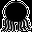

Results


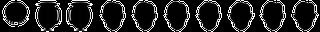

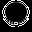

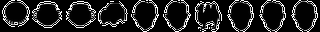

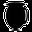

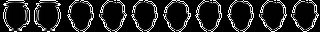

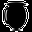

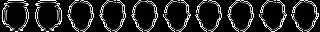

Query 


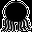

Results


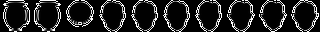

Recall@k: 0.08
Precision@k: 0.10
Query 


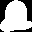

Results


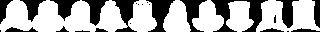

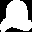

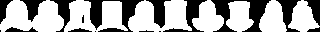

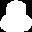

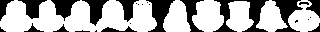

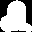

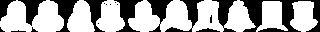

Query 


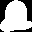

Results


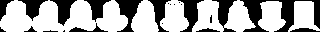

Recall@k: 0.60
Precision@k: 0.90
Query 


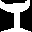

Results


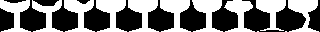

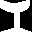

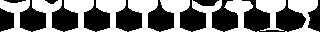

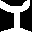

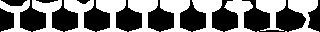

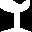

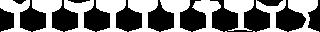

Query 


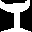

Results


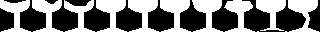

Recall@k: 0.71
Precision@k: 1.00
Query 


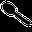

Results


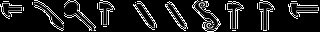

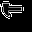

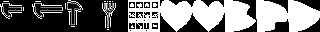

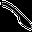

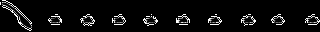

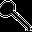

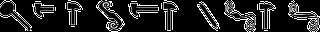

Query 


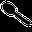

Results


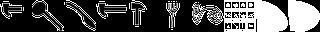

Recall@k: 0.12
Precision@k: 0.20
Query 


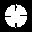

Results


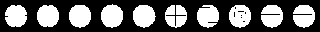

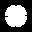

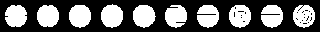

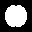

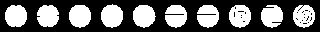

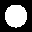

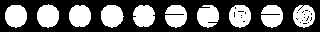

Query 


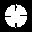

Results


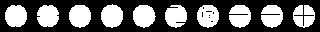

Recall@k: 0.67
Precision@k: 1.00
Query 


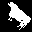

Results


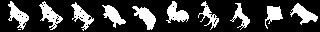

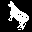

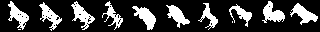

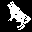

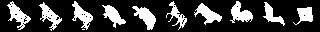

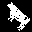

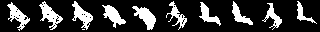

Query 


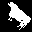

Results


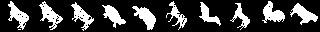

Recall@k: 0.33
Precision@k: 0.40
Query 


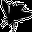

Results


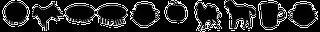

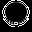

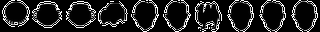

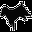

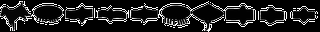

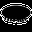

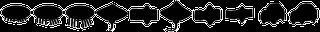

Query 


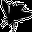

Results


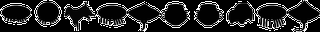

Recall@k: 0.00
Precision@k: 0.00
Query 


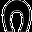

Results


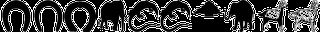

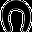

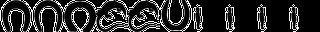

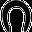

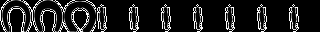

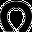

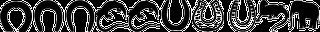

Query 


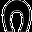

Results


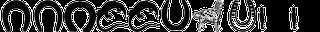

Recall@k: 0.33
Precision@k: 0.50
Query 


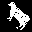

Results


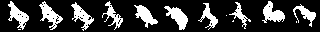

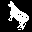

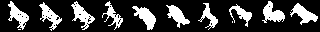

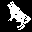

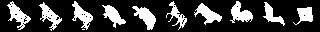

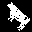

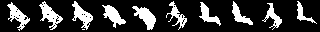

Query 


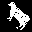

Results


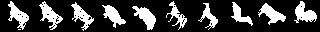

Recall@k: 0.33
Precision@k: 0.40
Query 


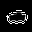

Results


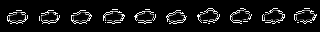

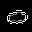

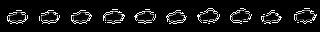

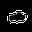

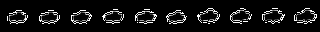

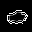

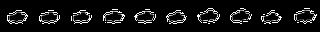

Query 


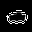

Results


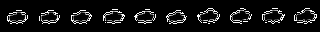

Recall@k: 0.59
Precision@k: 1.00
Query 


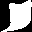

Results


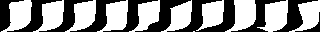

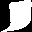

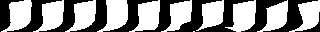

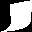

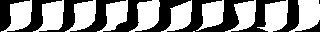

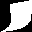

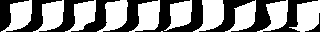

Query 


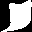

Results


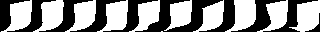

Recall@k: 0.67
Precision@k: 1.00
Query 


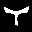

Results


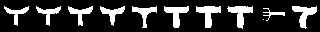

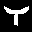

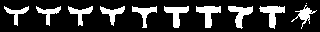

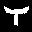

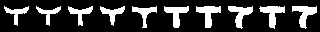

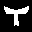

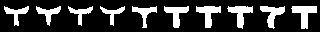

Query 


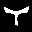

Results


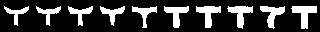

Recall@k: 0.62
Precision@k: 1.00
Query 


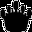

Results


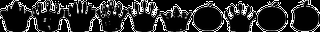

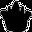

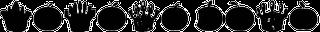

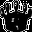

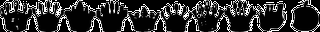

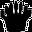

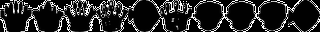

Query 


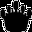

Results


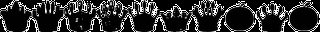

Recall@k: 0.47
Precision@k: 0.80
Query 


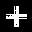

Results


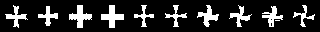

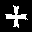

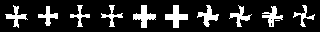

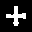

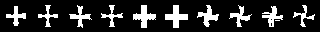

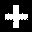

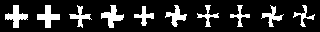

Query 


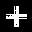

Results


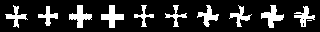

Recall@k: 0.71
Precision@k: 1.00
Query 


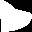

Results


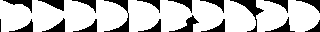

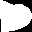

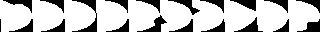

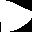

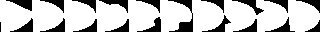

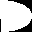

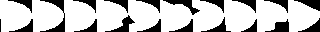

Query 


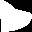

Results


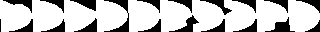

Recall@k: 0.71
Precision@k: 1.00
Query 


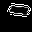

Results


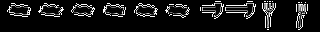

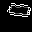

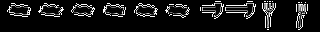

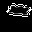

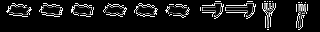

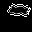

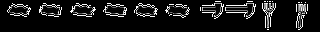

Query 


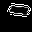

Results


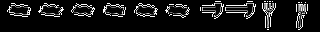

Recall@k: 0.40
Precision@k: 0.60
Query 


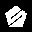

Results


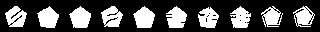

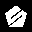

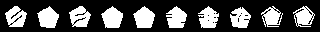

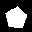

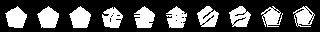

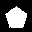

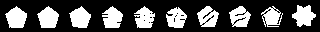

Query 


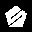

Results


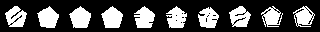

Recall@k: 0.56
Precision@k: 1.00
Query 


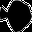

Results


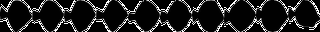

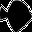

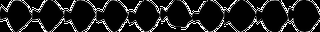

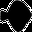

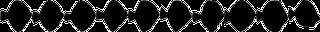

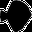

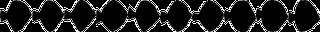

Query 


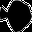

Results


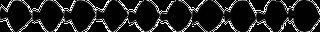

Recall@k: 0.71
Precision@k: 1.00
Query 


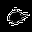

Results


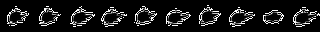

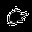

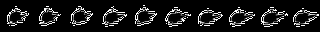

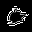

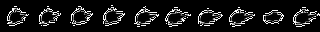

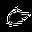

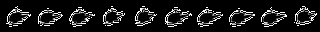

Query 


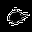

Results


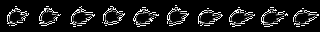

Recall@k: 0.91
Precision@k: 1.00
Query 


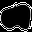

Results


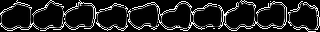

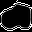

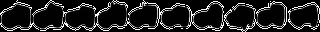

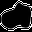

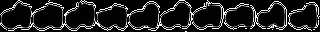

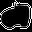

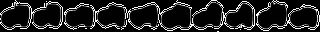

Query 


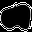

Results


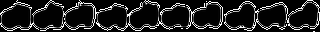

Recall@k: 0.56
Precision@k: 1.00
Query 


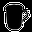

Results


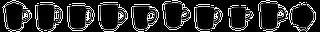

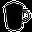

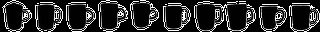

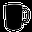

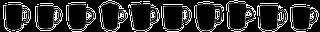

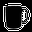

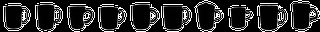

Query 


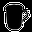

Results


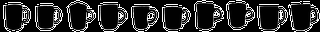

Recall@k: 0.62
Precision@k: 1.00
Query 


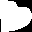

Results


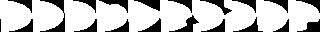

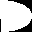

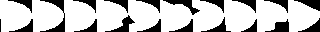

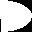

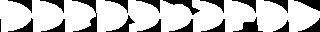

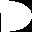

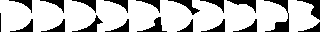

Query 


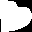

Results


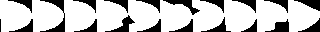

Recall@k: 0.71
Precision@k: 1.00
Query 


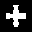

Results


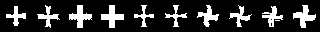

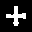

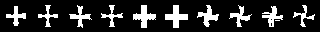

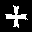

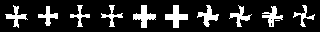

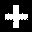

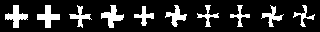

Query 


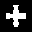

Results


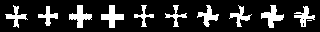

Recall@k: 0.71
Precision@k: 1.00
Query 


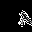

Results


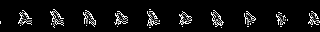

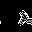

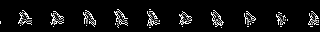

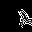

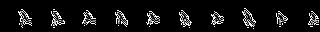

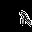

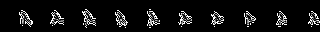

Query 


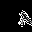

Results


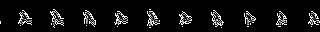

Recall@k: 0.56
Precision@k: 1.00
Query 


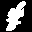

Results


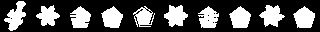

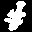

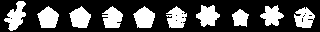

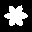

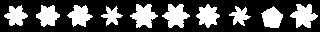

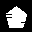

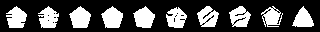

Query 


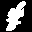

Results


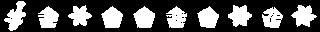

Recall@k: 0.06
Precision@k: 0.10
Query 


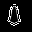

Results


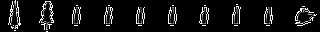

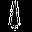

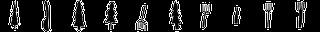

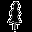

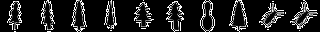

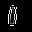

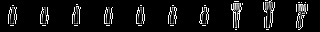

Query 


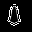

Results


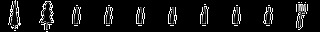

Recall@k: 0.00
Precision@k: 0.00
Query 


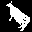

Results


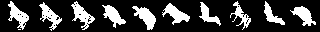

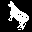

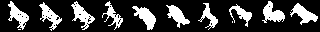

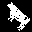

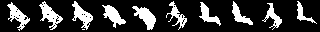

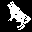

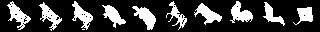

Query 


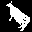

Results


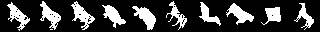

Recall@k: 0.33
Precision@k: 0.40
Query 


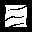

Results


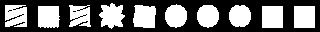

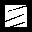

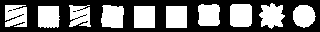

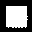

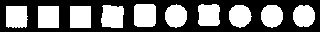

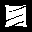

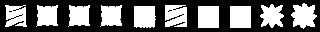

Query 


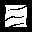

Results


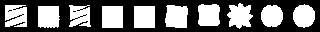

Recall@k: 0.50
Precision@k: 0.70
Query 


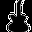

Results


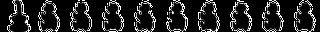

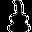

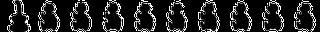

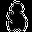

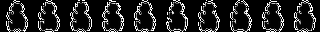

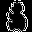

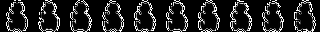

Query 


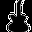

Results


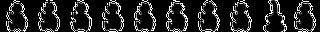

Recall@k: 0.07
Precision@k: 0.10
Query 


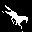

Results


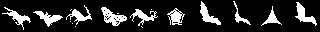

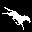

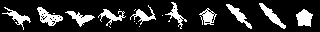

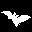

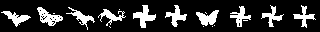

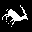

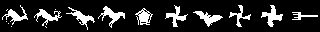

Query 


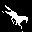

Results


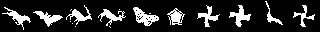

Recall@k: 0.07
Precision@k: 0.10
Query 


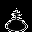

Results


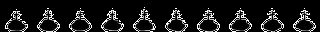

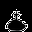

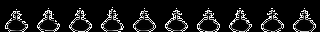

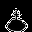

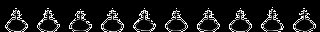

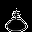

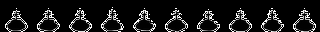

Query 


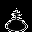

Results


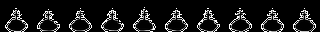

Recall@k: 0.59
Precision@k: 1.00
Query 


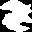

Results


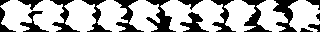

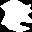

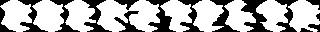

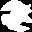

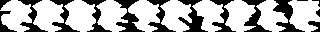

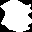

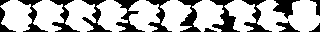

Query 


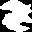

Results


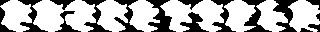

Recall@k: 0.67
Precision@k: 1.00
Query 


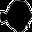

Results


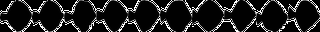

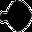

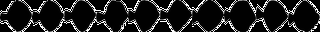

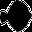

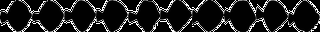

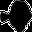

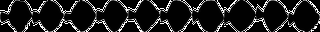

Query 


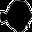

Results


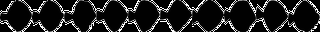

Recall@k: 0.71
Precision@k: 1.00
Query 


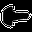

Results


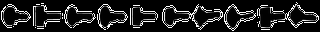

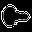

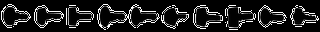

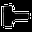

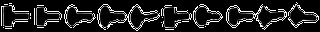

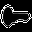

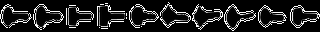

Query 


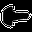

Results


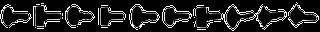

Recall@k: 0.71
Precision@k: 1.00
Query 


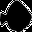

Results


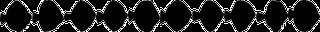

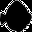

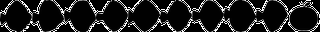

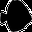

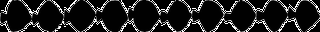

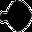

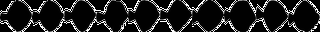

Query 


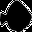

Results


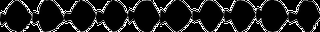

Recall@k: 0.71
Precision@k: 1.00
Query 


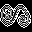

Results


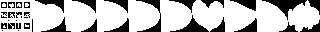

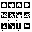

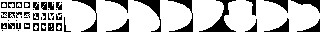

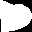

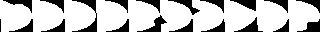

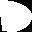

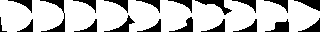

Query 


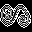

Results


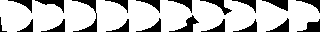

Recall@k: 0.00
Precision@k: 0.00
Query 


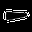

Results


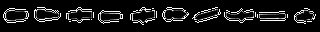

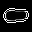

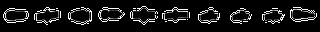

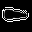

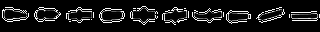

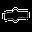

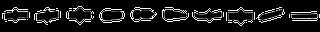

Query 


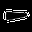

Results


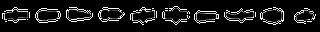

Recall@k: 0.25
Precision@k: 0.40
Query 


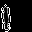

Results


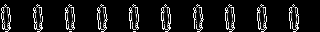

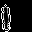

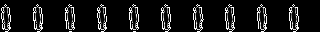

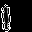

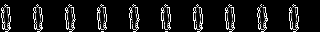

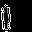

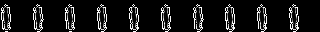

Query 


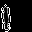

Results


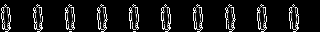

Recall@k: 0.53
Precision@k: 1.00
Query 


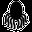

Results


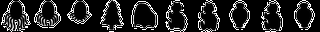

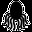

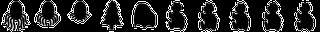

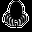

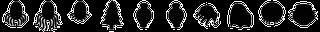

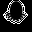

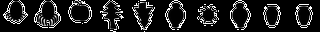

Query 


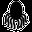

Results


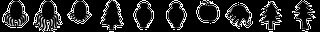

Recall@k: 0.23
Precision@k: 0.30
Query 


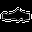

Results


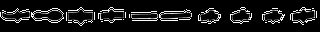

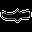

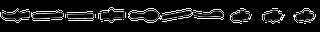

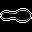

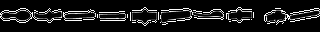

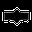

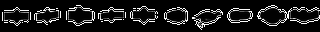

Query 


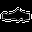

Results


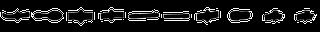

Recall@k: 0.29
Precision@k: 0.40
Query 


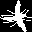

Results


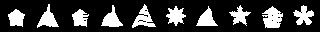

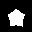

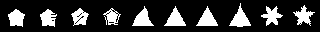

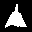

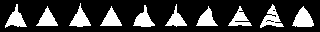

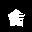

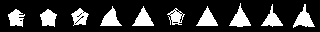

Query 


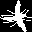

Results


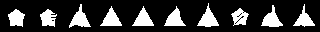

Recall@k: 0.00
Precision@k: 0.00
Query 


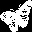

Results


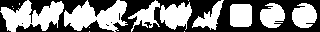

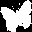

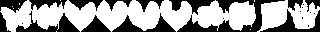

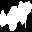

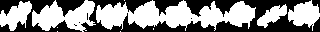

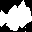

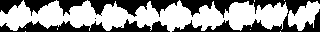

Query 


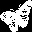

Results


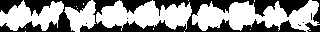

Recall@k: 0.07
Precision@k: 0.10
Query 


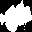

Results


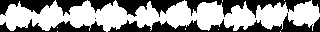

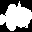

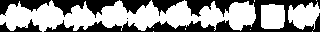

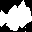

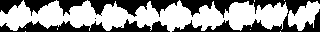

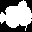

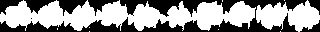

Query 


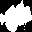

Results


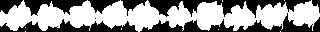

Recall@k: 0.67
Precision@k: 1.00
Query 


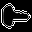

Results


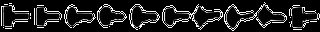

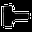

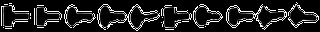

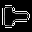

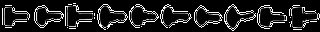

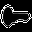

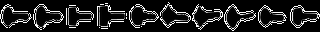

Query 


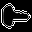

Results


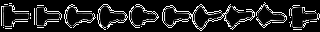

Recall@k: 0.71
Precision@k: 1.00
Query 


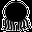

Results


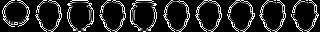

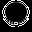

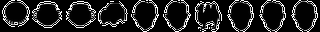

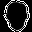

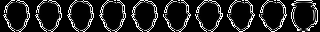

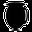

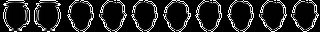

Query 


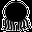

Results


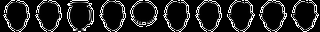

Recall@k: 0.08
Precision@k: 0.10
Query 


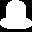

Results


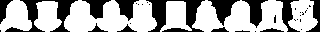

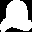

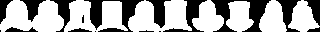

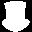

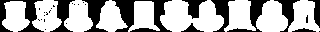

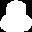

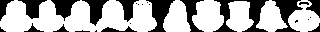

Query 


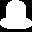

Results


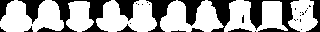

Recall@k: 0.60
Precision@k: 0.90
Query 


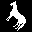

Results


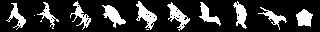

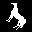

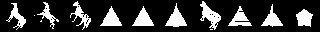

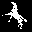

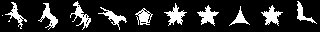

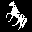

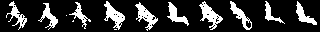

Query 


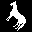

Results


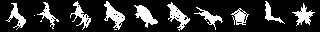

Recall@k: 0.27
Precision@k: 0.40
Query 


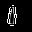

Results


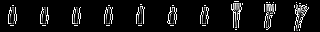

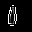

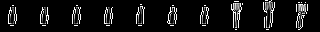

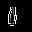

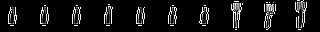

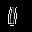

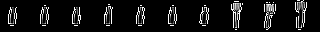

Query 


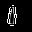

Results


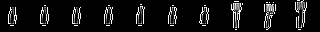

Recall@k: 0.50
Precision@k: 0.70
Query 


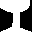

Results


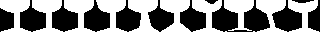

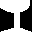

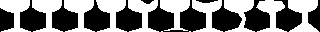

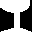

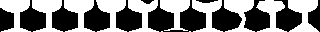

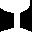

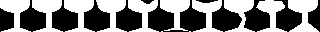

Query 


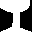

Results


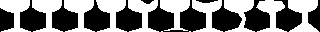

Recall@k: 0.71
Precision@k: 1.00
Query 


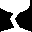

Results


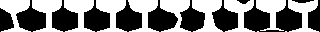

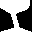

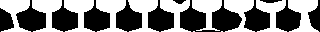

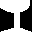

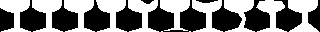

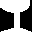

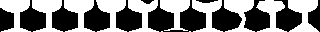

Query 


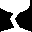

Results


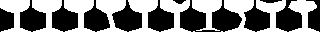

Recall@k: 0.71
Precision@k: 1.00
Query 


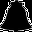

Results


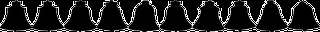

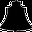

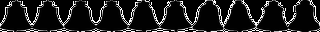

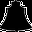

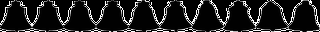

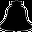

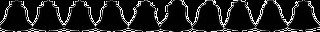

Query 


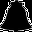

Results


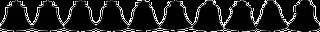

Recall@k: 0.67
Precision@k: 1.00
Query 


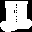

Results


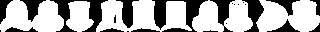

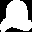

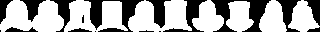

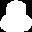

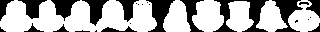

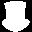

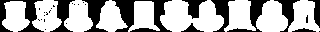

Query 


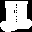

Results


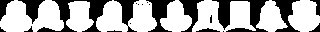

Recall@k: 0.60
Precision@k: 0.90
Query 


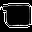

Results


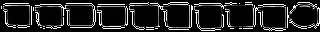

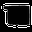

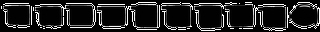

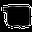

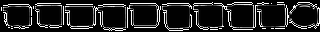

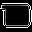

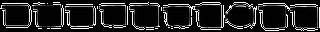

Query 


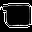

Results


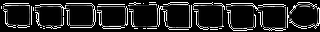

Recall@k: 0.69
Precision@k: 0.90
Query 


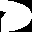

Results


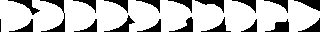

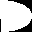

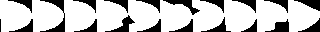

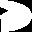

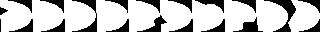

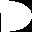

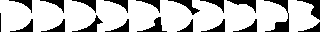

Query 


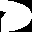

Results


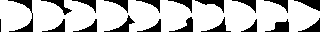

Recall@k: 0.71
Precision@k: 1.00
Query 


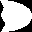

Results


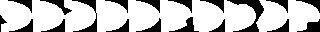

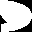

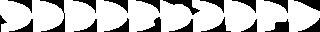

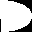

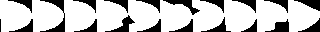

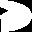

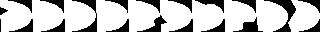

Query 


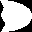

Results


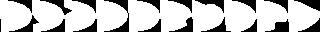

Recall@k: 0.71
Precision@k: 1.00
Query 


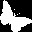

Results


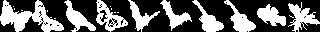

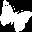

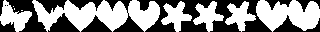

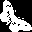

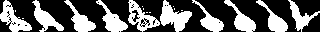

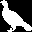

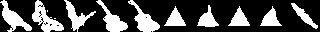

Query 


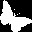

Results


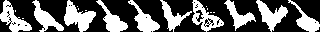

Recall@k: 0.21
Precision@k: 0.30
Query 


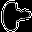

Results


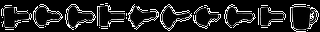

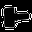

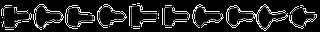

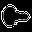

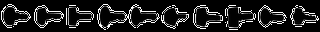

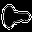

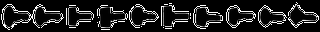

Query 


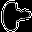

Results


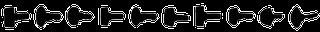

Recall@k: 0.71
Precision@k: 1.00
Query 


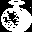

Results


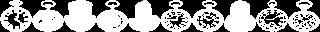

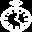

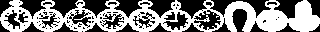

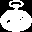

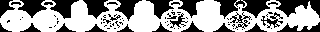

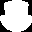

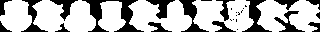

Query 


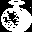

Results


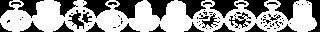

Recall@k: 0.35
Precision@k: 0.60
Query 


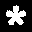

Results


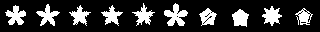

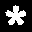

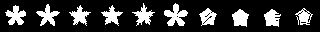

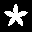

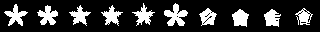

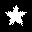

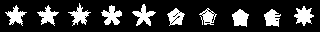

Query 


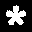

Results


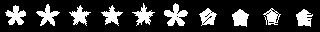

Recall@k: 0.43
Precision@k: 0.60
Query 


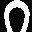

Results


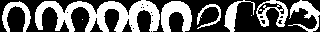

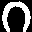

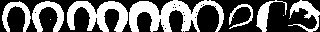

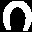

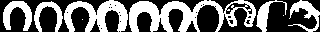

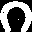

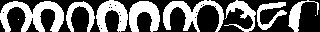

Query 


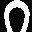

Results


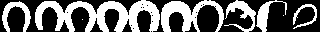

Recall@k: 0.47
Precision@k: 0.70
Query 


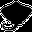

Results


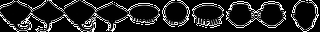

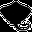

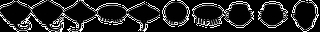

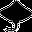

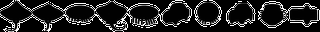

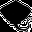

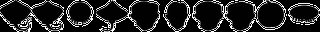

Query 


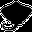

Results


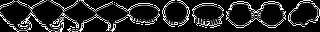

Recall@k: 0.36
Precision@k: 0.40
Query 


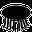

Results


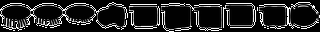

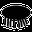

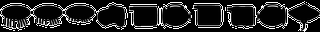

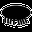

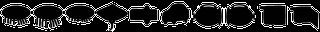

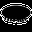

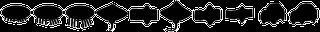

Query 


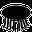

Results


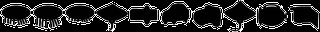

Recall@k: 0.23
Precision@k: 0.30
Query 


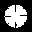

Results


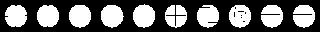

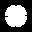

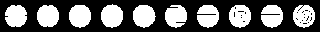

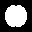

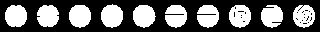

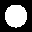

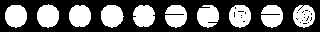

Query 


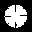

Results


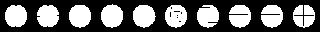

Recall@k: 0.67
Precision@k: 1.00
Query 


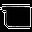

Results


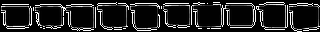

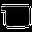

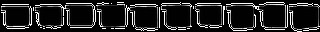

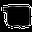

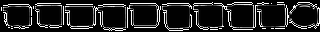

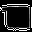

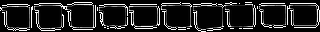

Query 


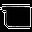

Results


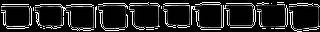

Recall@k: 0.77
Precision@k: 1.00
Query 


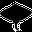

Results


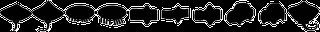

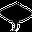

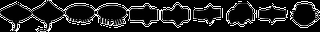

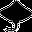

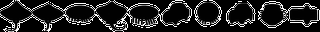

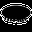

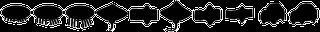

Query 


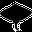

Results


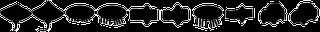

Recall@k: 0.18
Precision@k: 0.20
Query 


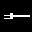

Results


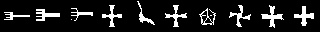

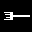

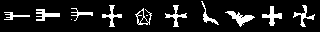

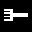

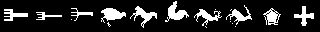

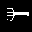

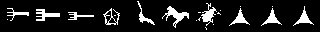

Query 


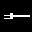

Results


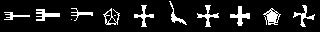

Recall@k: 0.23
Precision@k: 0.30
Query 


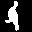

Results


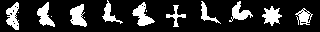

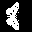

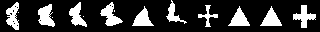

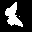

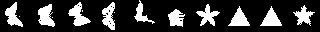

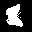

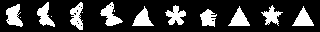

Query 


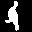

Results


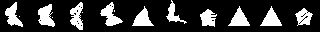

Recall@k: 0.00
Precision@k: 0.00
Query 


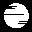

Results


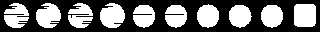

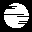

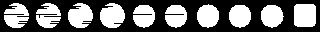

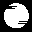

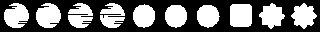

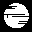

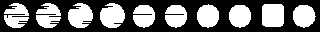

Query 


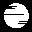

Results


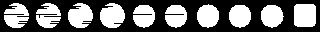

Recall@k: 0.60
Precision@k: 0.90
Query 


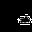

Results


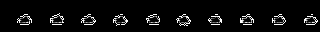

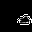

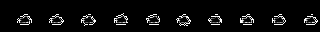

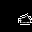

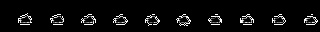

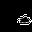

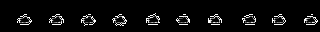

Query 


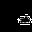

Results


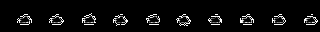

Recall@k: 0.67
Precision@k: 1.00
Query 


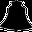

Results


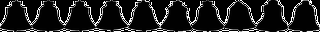

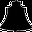

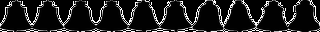

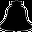

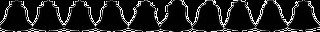

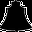

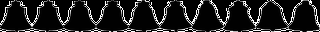

Query 


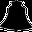

Results


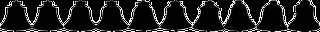

Recall@k: 0.67
Precision@k: 1.00
Query 


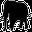

Results


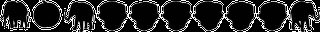

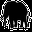

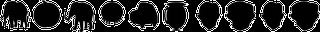

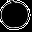

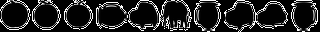

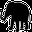

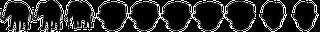

Query 


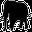

Results


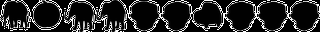

Recall@k: 0.18
Precision@k: 0.30
Query 


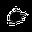

Results


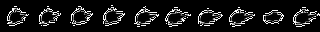

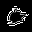

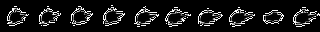

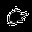

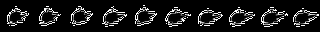

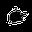

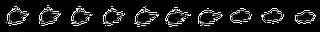

Query 


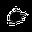

Results


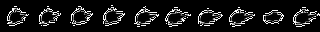

Recall@k: 0.82
Precision@k: 0.90
Query 


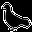

Results


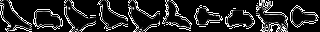

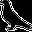

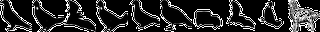

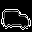

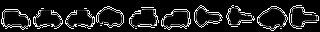

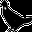

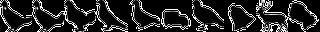

Query 


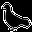

Results


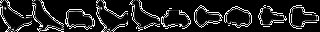

Recall@k: 0.24
Precision@k: 0.40
Query 


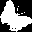

Results


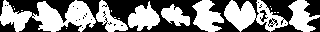

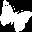

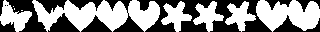

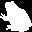

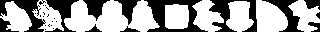

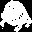

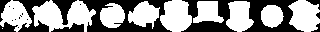

Query 


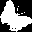

Results


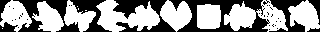

Recall@k: 0.07
Precision@k: 0.10
Query 


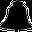

Results


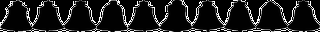

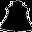

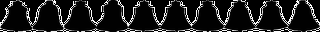

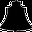

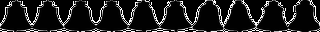

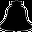

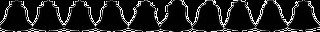

Query 


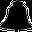

Results


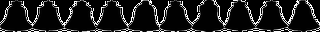

Recall@k: 0.67
Precision@k: 1.00
Query 


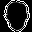

Results


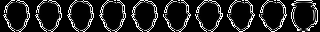

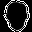

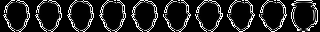

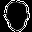

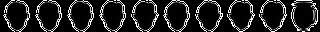

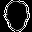

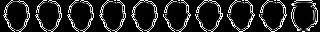

Query 


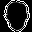

Results


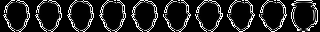

Recall@k: 0.56
Precision@k: 0.90
Query 


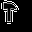

Results


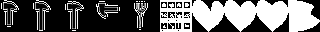

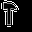

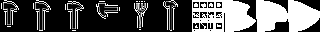

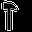

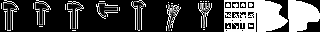

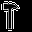

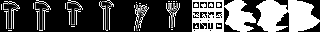

Query 


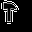

Results


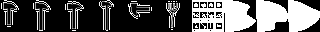

Recall@k: 0.31
Precision@k: 0.50
Query 


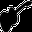

Results


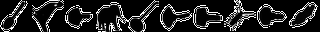

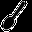

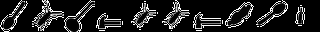

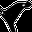

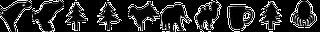

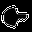

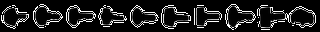

Query 


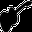

Results


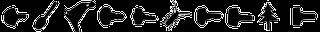

Recall@k: 0.00
Precision@k: 0.00
Query 


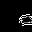

Results


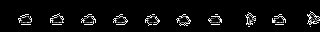

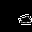

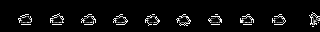

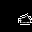

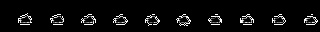

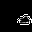

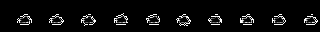

Query 


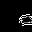

Results


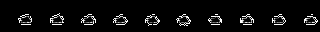

Recall@k: 0.67
Precision@k: 1.00
Query 


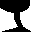

Results


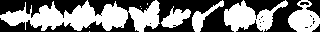

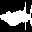

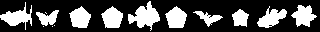

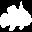

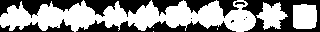

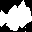

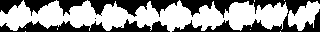

Query 


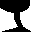

Results


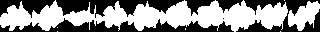

Recall@k: 0.00
Precision@k: 0.00
Query 


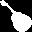

Results


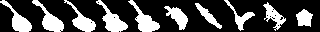

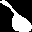

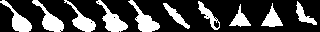

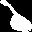

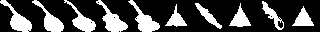

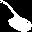

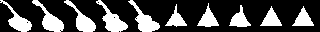

Query 


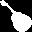

Results


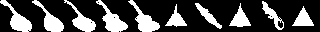

Recall@k: 0.33
Precision@k: 0.50
Query 


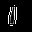

Results


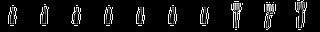

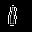

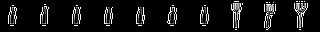

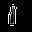

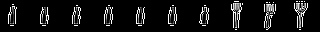

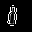

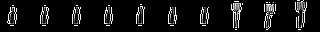

Query 


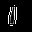

Results


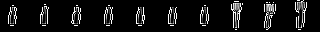

Recall@k: 0.50
Precision@k: 0.70
Query 


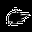

Results


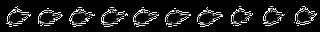

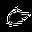

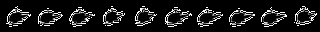

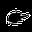

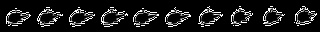

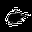

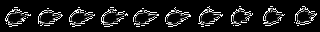

Query 


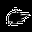

Results


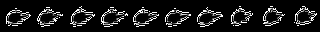

Recall@k: 0.91
Precision@k: 1.00
Query 


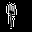

Results


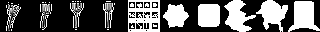

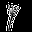

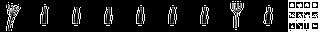

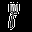

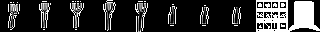

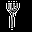

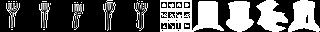

Query 


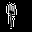

Results


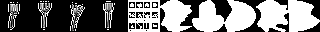

Recall@k: 0.31
Precision@k: 0.40
Query 


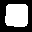

Results


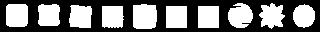

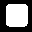

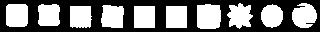

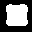

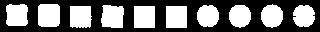

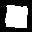

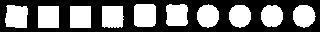

Query 


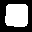

Results


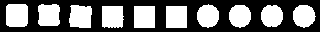

Recall@k: 0.43
Precision@k: 0.60
Query 


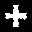

Results


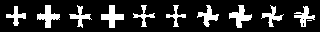

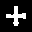

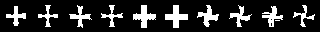

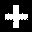

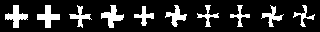

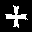

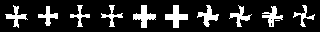

Query 


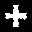

Results


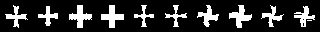

Recall@k: 0.71
Precision@k: 1.00
Query 


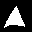

Results


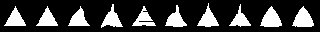

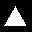

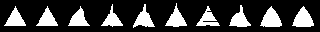

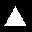

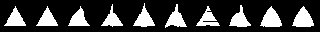

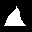

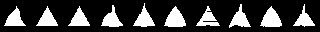

Query 


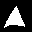

Results


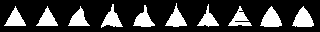

Recall@k: 0.62
Precision@k: 1.00
Query 


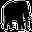

Results


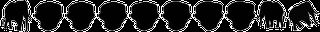

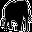

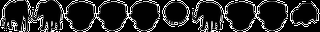

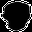

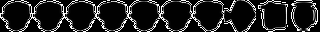

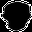

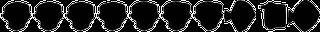

Query 


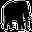

Results


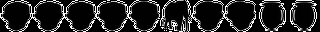

Recall@k: 0.06
Precision@k: 0.10
Query 


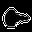

Results


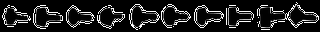

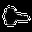

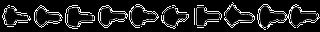

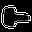

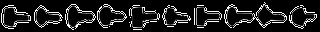

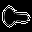

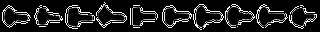

Query 


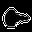

Results


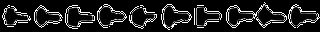

Recall@k: 0.71
Precision@k: 1.00
Query 


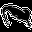

Results


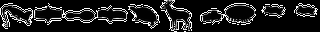

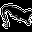

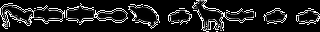

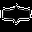

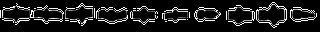

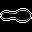

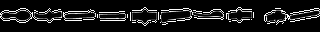

Query 


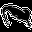

Results


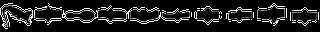

Recall@k: 0.06
Precision@k: 0.10
Query 


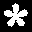

Results


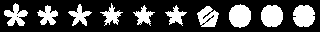

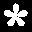

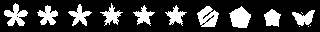

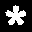

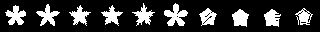

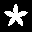

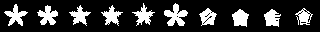

Query 


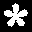

Results


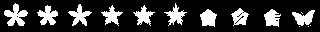

Recall@k: 0.43
Precision@k: 0.60
Query 


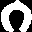

Results


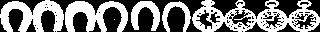

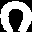

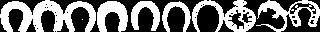

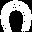

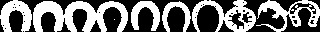

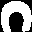

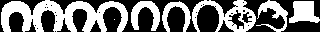

Query 


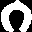

Results


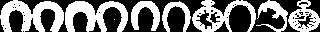

Recall@k: 0.47
Precision@k: 0.70
Query 


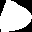

Results


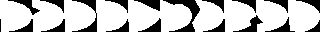

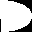

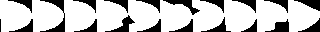

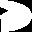

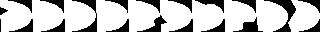

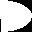

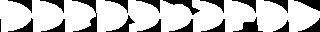

Query 


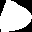

Results


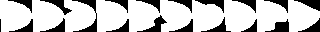

Recall@k: 0.71
Precision@k: 1.00
Query 


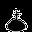

Results


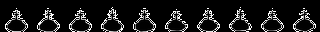

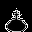

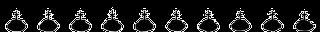

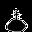

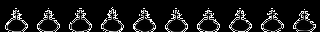

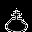

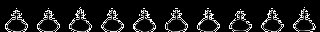

Query 


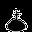

Results


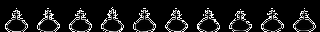

Recall@k: 0.59
Precision@k: 1.00
Query 


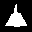

Results


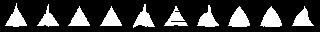

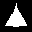

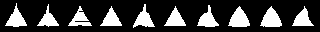

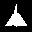

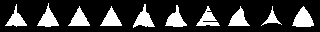

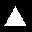

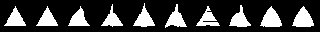

Query 


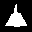

Results


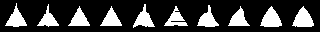

Recall@k: 0.62
Precision@k: 1.00
Query 


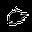

Results


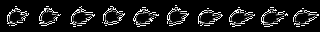

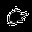

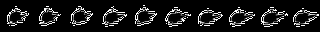

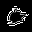

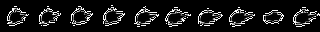

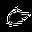

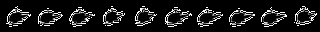

Query 


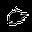

Results


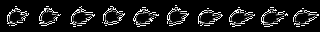

Recall@k: 0.91
Precision@k: 1.00
Query 


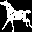

Results


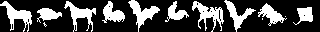

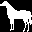

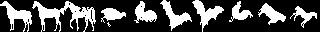

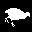

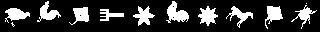

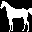

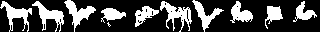

Query 


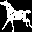

Results


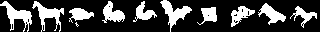

Recall@k: 0.20
Precision@k: 0.30
Query 


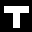

Results


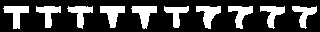

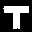

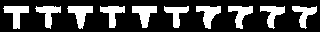

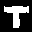

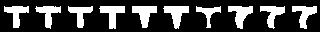

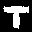

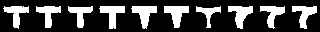

Query 


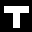

Results


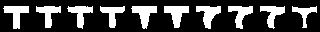

Recall@k: 0.62
Precision@k: 1.00
Query 


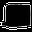

Results


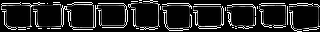

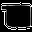

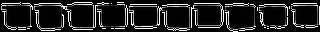

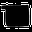

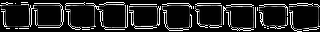

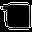

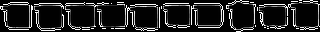

Query 


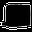

Results


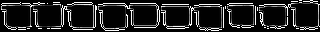

Recall@k: 0.77
Precision@k: 1.00
Query 


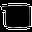

Results


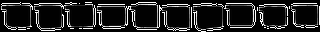

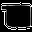

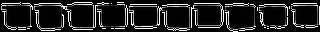

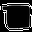

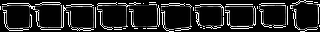

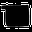

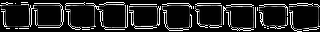

Query 


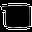

Results


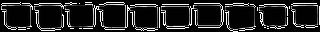

Recall@k: 0.77
Precision@k: 1.00
Query 


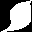

Results


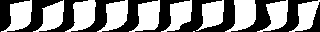

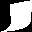

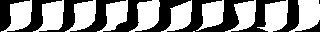

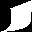

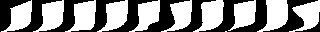

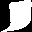

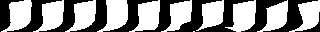

Query 


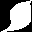

Results


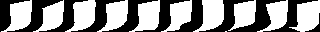

Recall@k: 0.67
Precision@k: 1.00
Query 


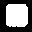

Results


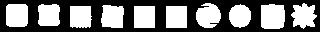

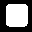

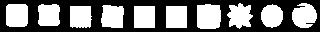

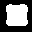

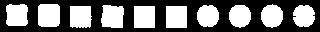

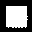

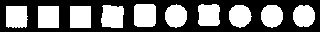

Query 


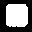

Results


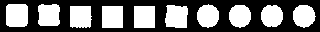

Recall@k: 0.43
Precision@k: 0.60
Query 


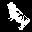

Results


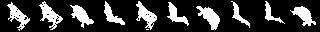

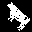

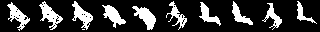

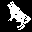

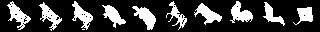

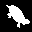

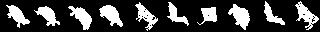

Query 


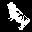

Results


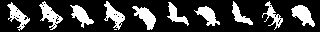

Recall@k: 0.25
Precision@k: 0.30
Query 


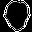

Results


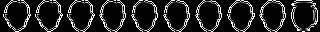

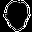

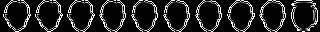

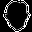

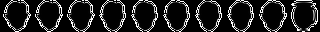

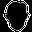

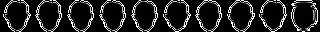

Query 


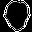

Results


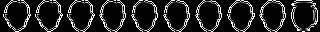

Recall@k: 0.56
Precision@k: 0.90
Query 


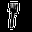

Results


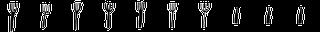

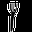

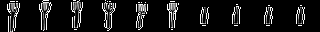

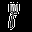

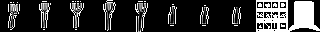

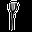

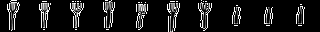

Query 


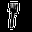

Results


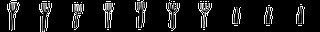

Recall@k: 0.54
Precision@k: 0.70
Query 


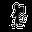

Results


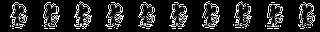

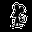

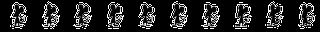

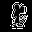

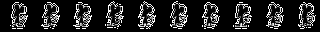

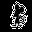

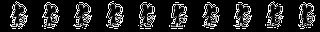

Query 


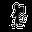

Results


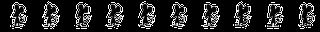

Recall@k: 0.56
Precision@k: 1.00
Query 


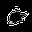

Results


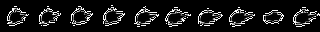

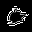

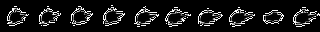

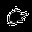

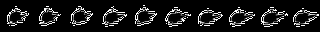

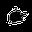

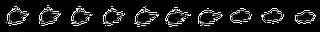

Query 


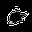

Results


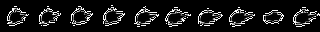

Recall@k: 0.82
Precision@k: 0.90
Query 


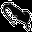

Results


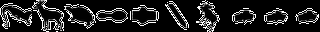

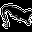

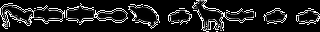

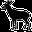

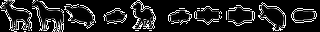

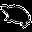

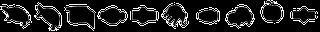

Query 


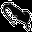

Results


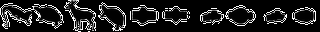

Recall@k: 0.06
Precision@k: 0.10
Query 


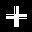

Results


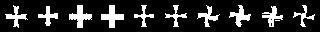

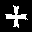

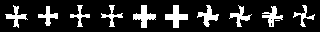

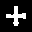

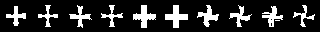

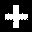

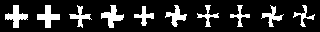

Query 


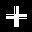

Results


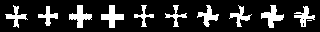

Recall@k: 0.71
Precision@k: 1.00
Query 


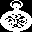

Results


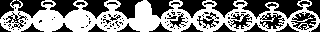

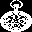

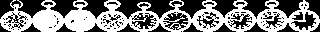

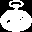

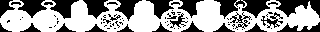

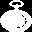

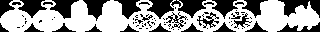

Query 


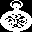

Results


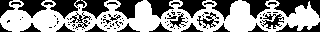

Recall@k: 0.41
Precision@k: 0.70
Query 


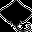

Results


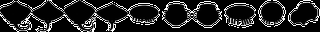

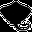

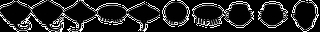

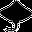

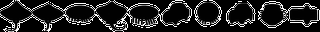

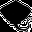

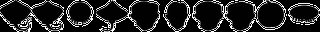

Query 


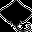

Results


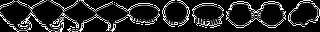

Recall@k: 0.36
Precision@k: 0.40
Query 


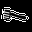

Results


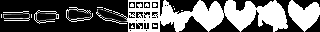

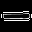

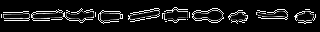

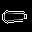

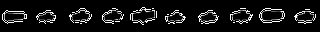

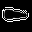

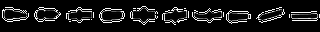

Query 


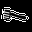

Results


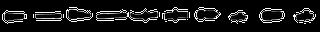

Recall@k: 0.00
Precision@k: 0.00
Query 


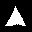

Results


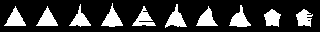

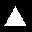

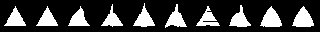

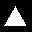

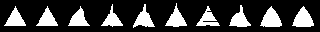

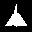

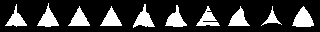

Query 


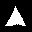

Results


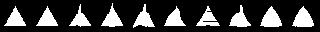

Recall@k: 0.62
Precision@k: 1.00
Query 


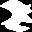

Results


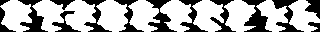

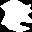

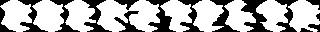

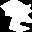

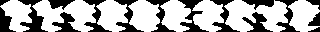

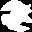

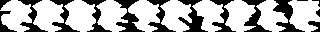

Query 


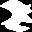

Results


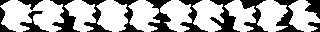

Recall@k: 0.67
Precision@k: 1.00
Query 


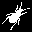

Results


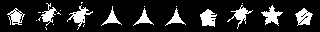

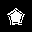

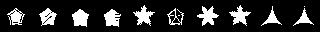

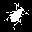

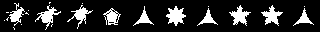

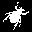

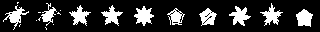

Query 


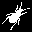

Results


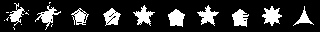

Recall@k: 0.12
Precision@k: 0.20
Query 


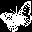

Results


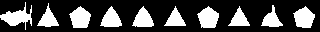

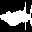

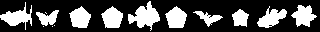

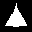

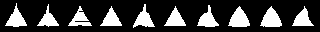

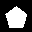

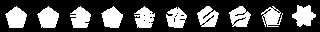

Query 


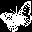

Results


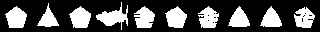

Recall@k: 0.00
Precision@k: 0.00
Query 


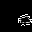

Results


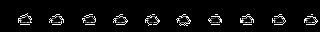

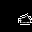

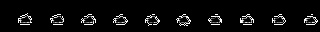

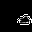

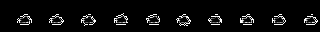

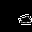

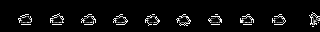

Query 


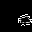

Results


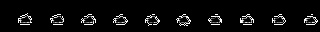

Recall@k: 0.67
Precision@k: 1.00
Query 


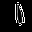

Results


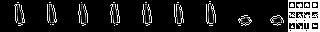

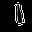

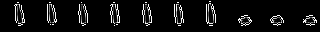

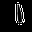

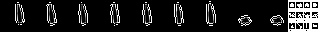

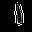

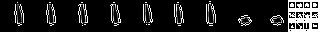

Query 


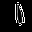

Results


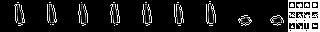

Recall@k: 0.50
Precision@k: 0.70
Query 


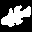

Results


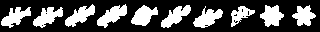

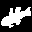

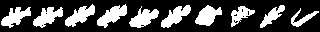

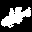

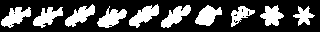

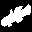

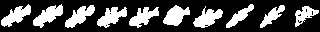

Query 


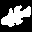

Results


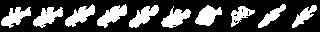

Recall@k: 0.47
Precision@k: 0.80
Query 


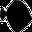

Results


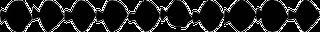

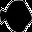

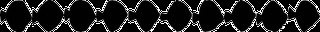

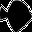

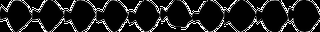

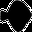

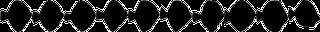

Query 


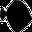

Results


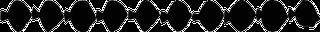

Recall@k: 0.71
Precision@k: 1.00
Query 


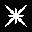

Results


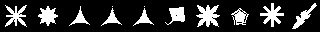

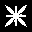

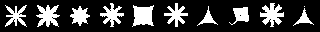

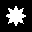

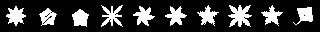

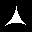

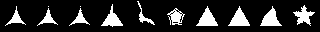

Query 


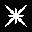

Results


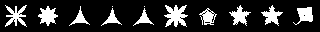

Recall@k: 0.20
Precision@k: 0.30
Query 


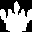

Results


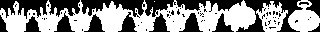

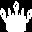

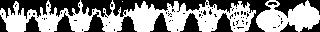

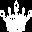

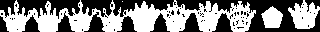

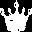

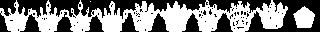

Query 


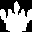

Results


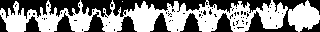

Recall@k: 0.53
Precision@k: 0.90
Query 


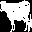

Results


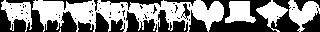

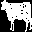

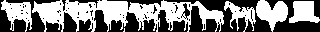

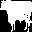

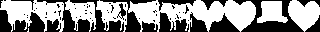

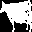

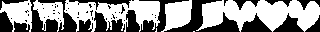

Query 


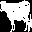

Results


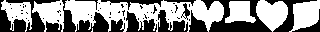

Recall@k: 0.50
Precision@k: 0.60
Query 


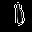

Results


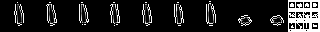

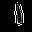

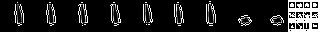

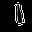

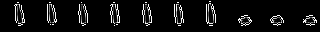

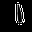

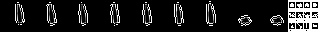

Query 


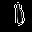

Results


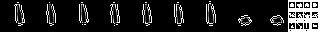

Recall@k: 0.50
Precision@k: 0.70
Query 


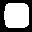

Results


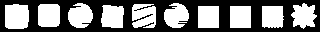

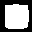

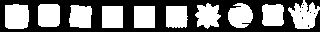

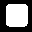

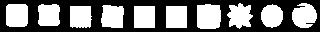

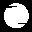

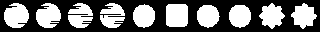

Query 


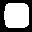

Results


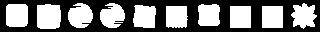

Recall@k: 0.50
Precision@k: 0.70
Query 


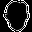

Results


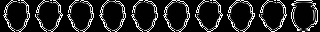

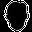

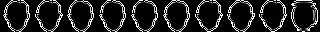

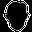

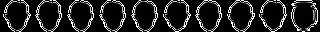

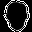

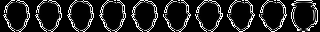

Query 


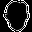

Results


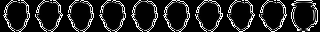

Recall@k: 0.56
Precision@k: 0.90
Query 


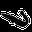

Results


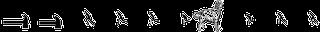

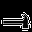

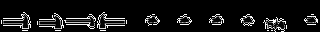

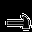

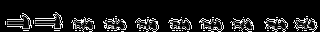

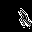

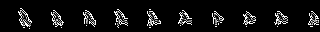

Query 


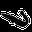

Results


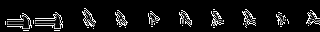

Recall@k: 0.00
Precision@k: 0.00
Query 


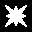

Results


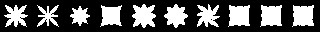

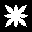

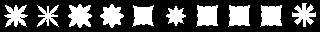

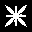

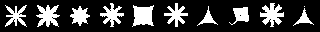

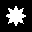

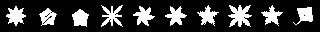

Query 


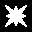

Results


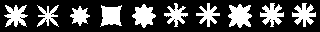

Recall@k: 0.60
Precision@k: 0.90
Query 


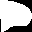

Results


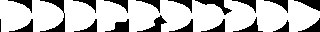

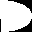

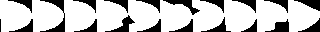

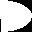

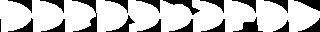

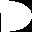

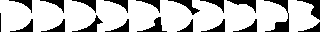

Query 


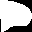

Results


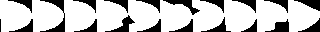

Recall@k: 0.71
Precision@k: 1.00
Query 


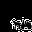

Results


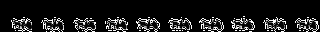

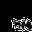

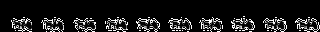

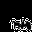

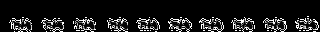

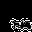

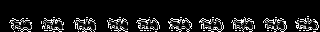

Query 


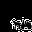

Results


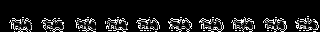

Recall@k: 0.53
Precision@k: 1.00
Query 


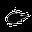

Results


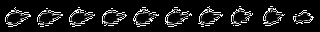

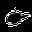

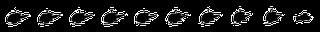

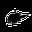

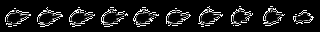

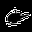

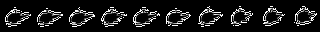

Query 


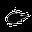

Results


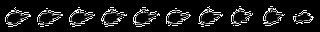

Recall@k: 0.82
Precision@k: 0.90
Query 


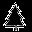

Results


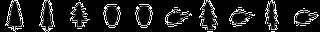

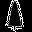

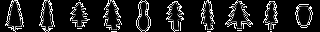

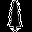

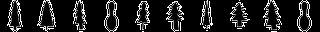

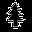

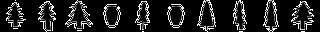

Query 


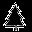

Results


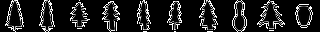

Recall@k: 0.50
Precision@k: 0.80
Query 


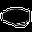

Results


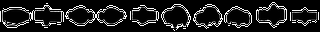

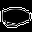

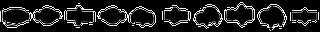

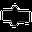

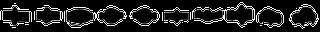

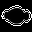

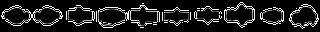

Query 


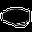

Results


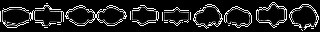

Recall@k: 0.19
Precision@k: 0.30
Query 


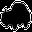

Results


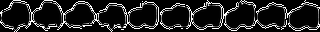

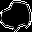

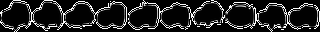

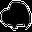

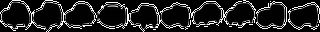

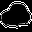

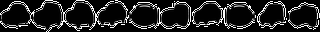

Query 


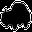

Results


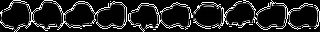

Recall@k: 0.29
Precision@k: 0.50
Query 


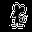

Results


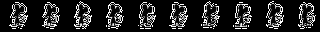

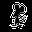

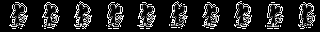

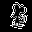

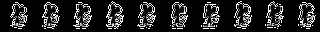

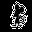

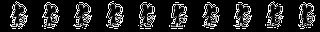

Query 


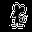

Results


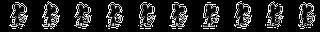

Recall@k: 0.56
Precision@k: 1.00
Query 


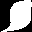

Results


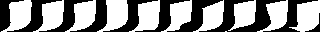

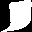

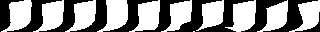

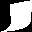

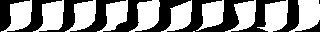

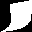

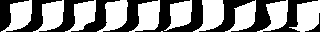

Query 


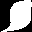

Results


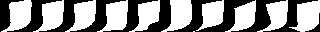

Recall@k: 0.67
Precision@k: 1.00
Query 


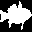

Results


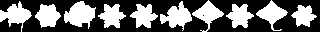

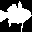

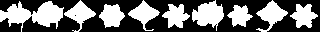

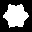

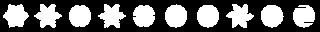

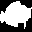

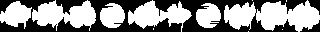

Query 


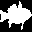

Results


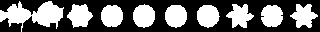

Recall@k: 0.13
Precision@k: 0.20
Query 


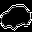

Results


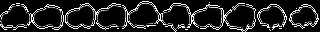

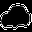

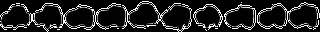

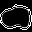

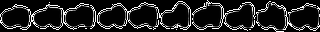

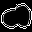

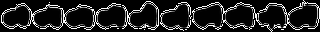

Query 


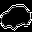

Results


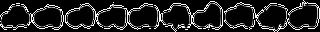

Recall@k: 0.18
Precision@k: 0.30
Query 


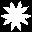

Results


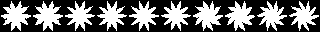

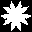

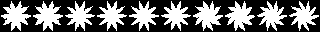

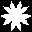

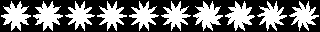

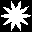

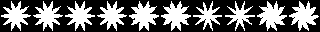

Query 


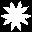

Results


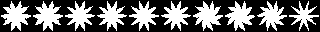

Recall@k: 0.62
Precision@k: 1.00
Query 


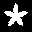

Results


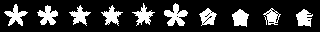

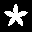

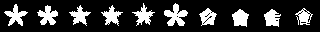

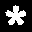

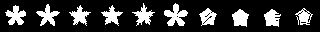

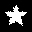

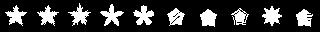

Query 


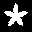

Results


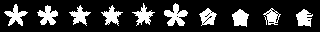

Recall@k: 0.43
Precision@k: 0.60
Query 


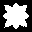

Results


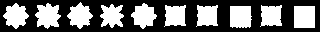

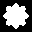

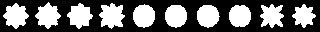

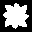

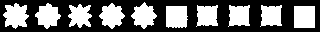

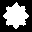

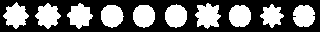

Query 


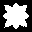

Results


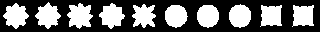

Recall@k: 0.33
Precision@k: 0.50
Query 


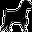

Results


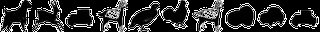

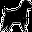

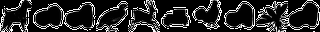

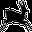

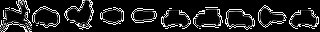

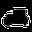

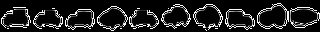

Query 


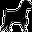

Results


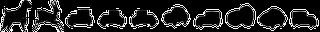

Recall@k: 0.06
Precision@k: 0.10
Query 


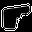

Results


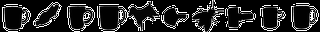

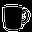

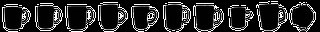

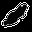

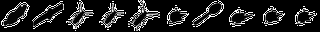

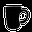

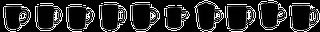

Query 


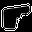

Results


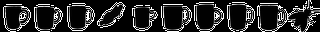

Recall@k: 0.00
Precision@k: 0.00
Query 


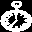

Results


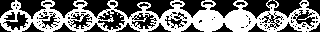

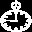

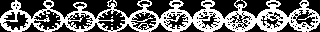

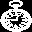

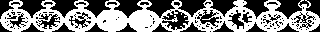

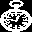

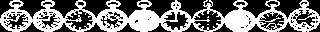

Query 


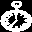

Results


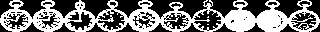

Recall@k: 0.59
Precision@k: 1.00
Query 


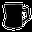

Results


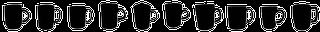

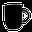

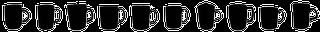

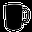

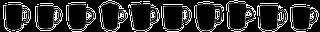

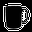

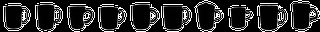

Query 


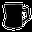

Results


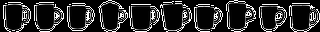

Recall@k: 0.62
Precision@k: 1.00
Query 


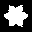

Results


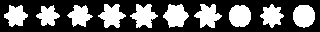

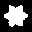

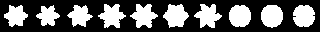

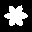

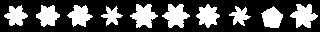

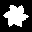

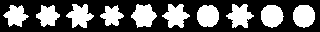

Query 


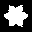

Results


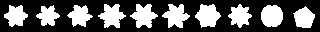

Recall@k: 0.41
Precision@k: 0.70
Query 


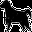

Results


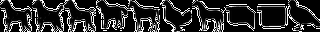

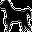

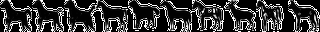

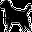

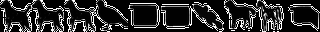

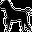

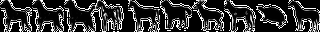

Query 


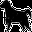

Results


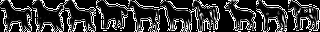

Recall@k: 0.28
Precision@k: 0.50
Query 


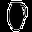

Results


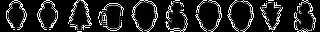

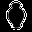

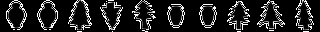

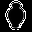

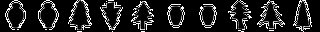

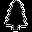

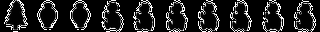

Query 


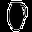

Results


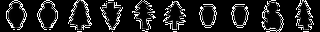

Recall@k: 0.25
Precision@k: 0.40
Query 


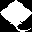

Results


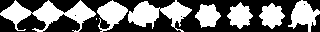

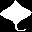

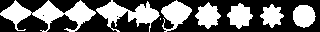

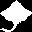

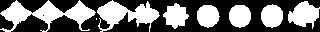

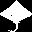

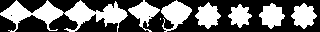

Query 


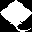

Results


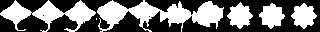

Recall@k: 0.45
Precision@k: 0.50
Query 


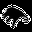

Results


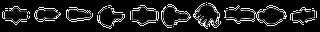

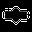

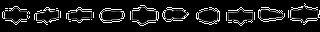

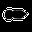

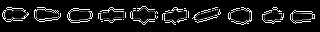

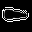

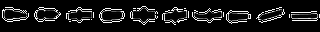

Query 


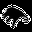

Results


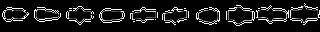

Recall@k: 0.00
Precision@k: 0.00
Query 


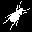

Results


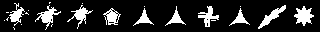

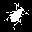

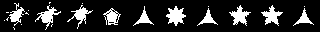

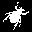

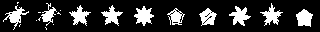

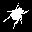

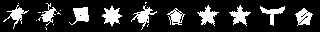

Query 


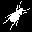

Results


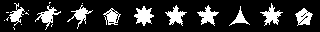

Recall@k: 0.19
Precision@k: 0.30
Query 


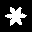

Results


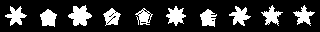

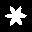

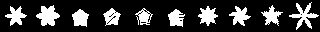

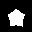

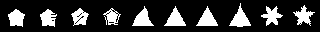

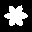

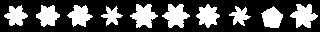

Query 


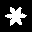

Results


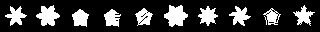

Recall@k: 0.24
Precision@k: 0.40
Query 


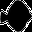

Results


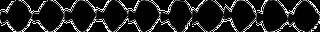

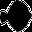

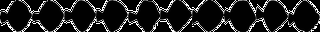

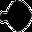

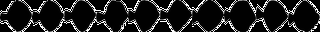

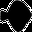

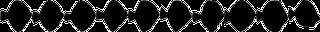

Query 


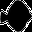

Results


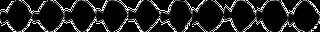

Recall@k: 0.71
Precision@k: 1.00
Query 


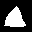

Results


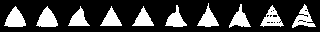

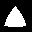

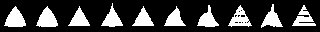

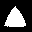

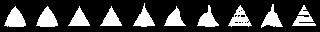

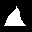

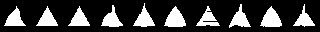

Query 


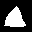

Results


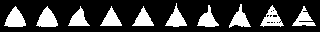

Recall@k: 0.62
Precision@k: 1.00
Query 


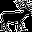

Results


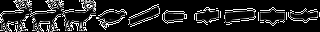

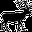

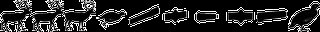

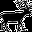

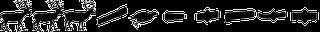

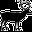

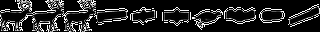

Query 


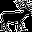

Results


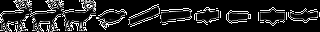

Recall@k: 0.16
Precision@k: 0.30
Query 


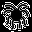

Results


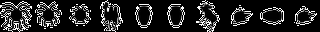

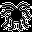

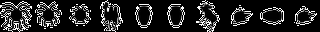

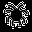

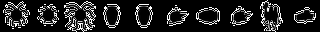

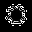

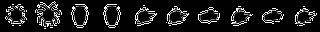

Query 


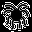

Results


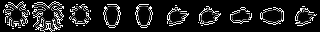

Recall@k: 0.23
Precision@k: 0.30
Query 


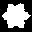

Results


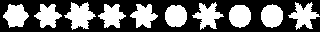

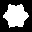

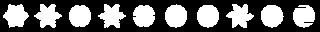

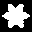

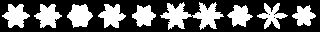

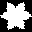

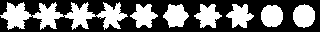

Query 


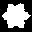

Results


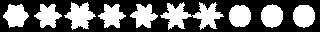

Recall@k: 0.41
Precision@k: 0.70
Query 


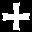

Results


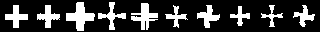

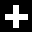

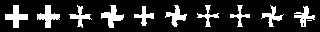

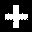

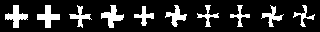

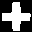

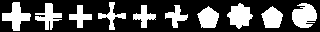

Query 


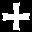

Results


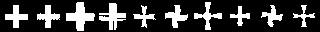

Recall@k: 0.71
Precision@k: 1.00
Query 


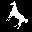

Results


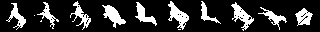

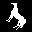

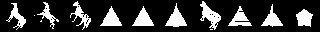

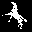

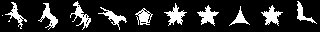

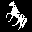

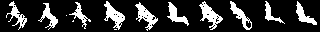

Query 


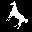

Results


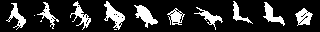

Recall@k: 0.27
Precision@k: 0.40
Query 


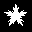

Results


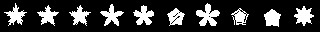

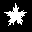

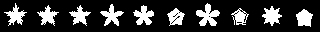

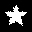

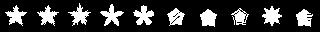

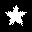

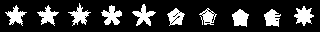

Query 


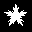

Results


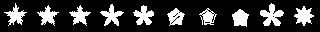

Recall@k: 0.43
Precision@k: 0.60
Query 


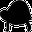

Results


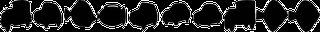

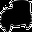

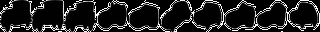

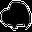

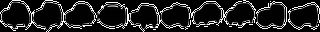

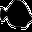

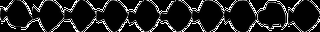

Query 


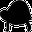

Results


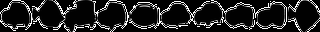

Recall@k: 0.00
Precision@k: 0.00
Query 


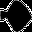

Results


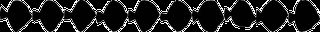

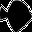

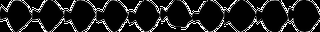

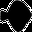

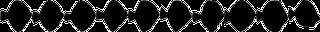

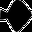

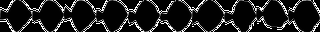

Query 


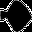

Results


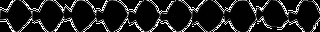

Recall@k: 0.71
Precision@k: 1.00
Query 


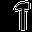

Results


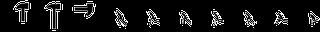

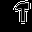

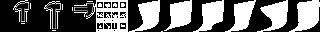

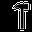

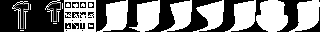

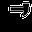

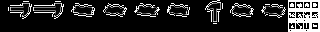

Query 


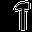

Results


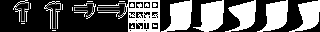

Recall@k: 0.25
Precision@k: 0.40
Query 


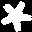

Results


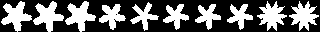

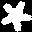

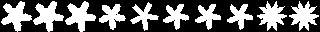

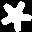

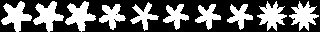

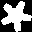

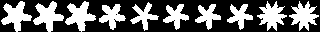

Query 


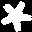

Results


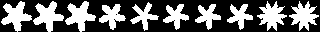

Recall@k: 0.57
Precision@k: 0.80
Query 


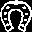

Results


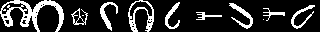

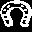

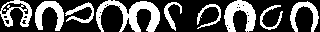

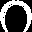

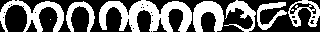

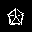

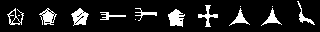

Query 


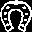

Results


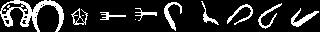

Recall@k: 0.13
Precision@k: 0.20
Query 


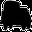

Results


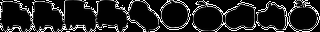

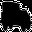

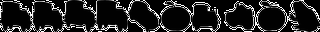

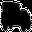

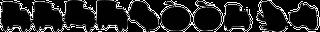

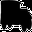

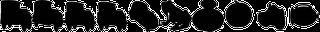

Query 


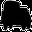

Results


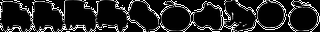

Recall@k: 0.28
Precision@k: 0.50
Query 


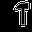

Results


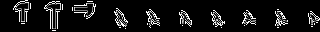

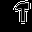

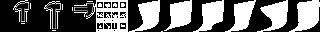

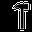

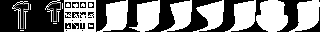

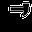

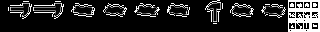

Query 


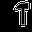

Results


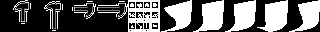

Recall@k: 0.25
Precision@k: 0.40
Query 


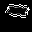

Results


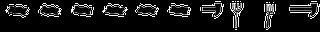

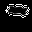

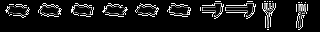

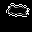

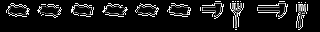

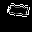

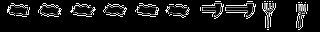

Query 


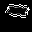

Results


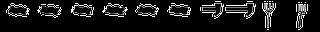

Recall@k: 0.40
Precision@k: 0.60
Query 


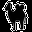

Results


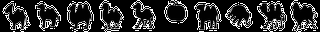

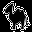

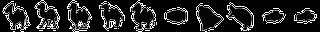

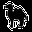

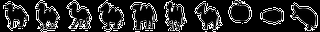

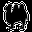

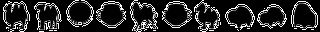

Query 


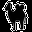

Results


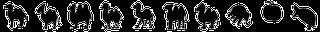

Recall@k: 0.39
Precision@k: 0.70
Query 


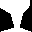

Results


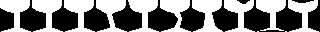

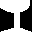

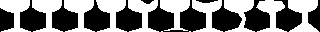

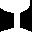

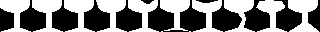

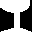

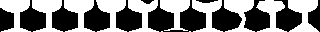

Query 


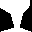

Results


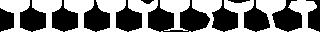

Recall@k: 0.71
Precision@k: 1.00
Query 


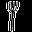

Results


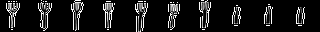

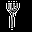

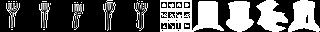

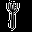

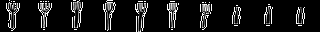

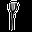

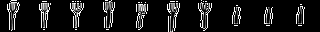

Query 


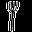

Results


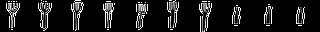

Recall@k: 0.54
Precision@k: 0.70
Query 


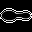

Results


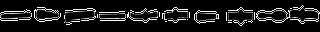

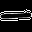

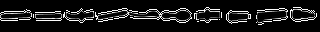

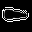

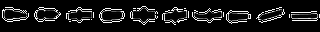

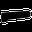

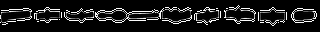

Query 


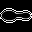

Results


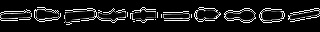

Recall@k: 0.06
Precision@k: 0.10
Query 


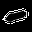

Results


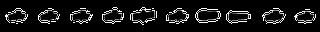

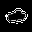

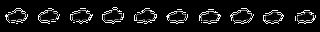

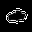

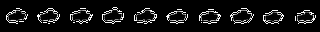

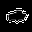

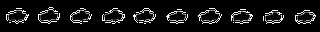

Query 


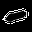

Results


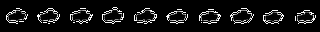

Recall@k: 0.00
Precision@k: 0.00
Query 


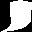

Results


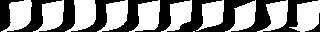

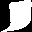

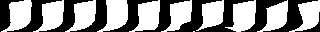

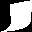

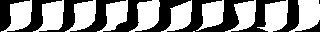

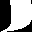

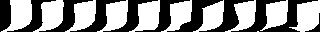

Query 


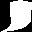

Results


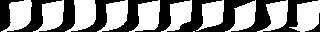

Recall@k: 0.67
Precision@k: 1.00
Query 


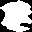

Results


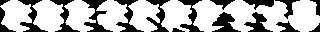

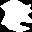

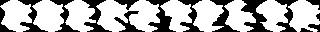

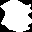

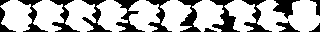

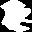

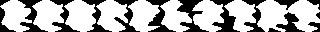

Query 


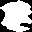

Results


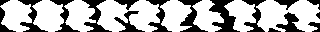

Recall@k: 0.67
Precision@k: 1.00
Query 


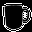

Results


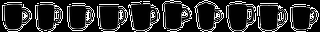

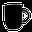

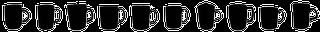

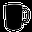

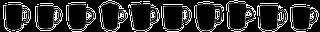

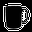

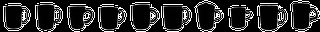

Query 


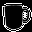

Results


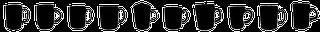

Recall@k: 0.62
Precision@k: 1.00
Query 


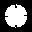

Results


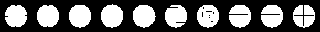

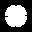

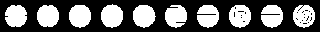

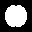

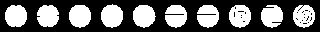

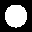

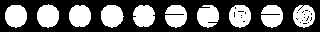

Query 


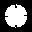

Results


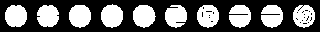

Recall@k: 0.67
Precision@k: 1.00
Query 


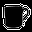

Results


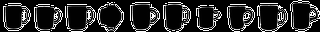

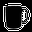

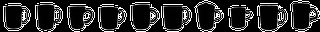

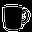

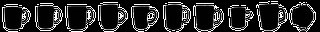

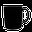

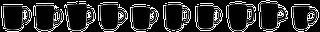

Query 


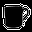

Results


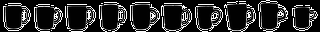

Recall@k: 0.62
Precision@k: 1.00
Query 


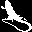

Results


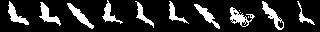

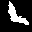

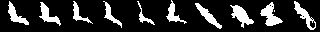

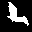

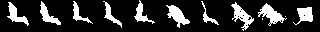

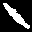

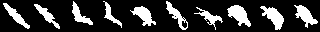

Query 


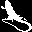

Results


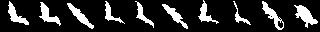

Recall@k: 0.06
Precision@k: 0.10
Query 


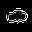

Results


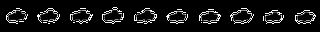

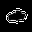

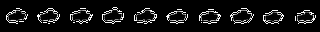

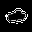

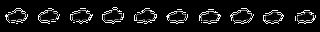

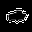

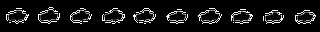

Query 


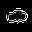

Results


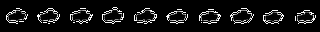

Recall@k: 0.59
Precision@k: 1.00
Query 


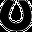

Results


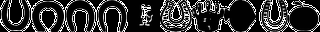

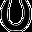

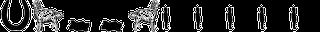

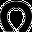

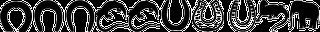

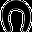

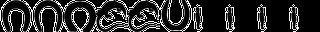

Query 


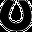

Results


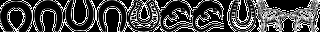

Recall@k: 0.40
Precision@k: 0.60
Query 


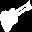

Results


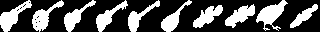

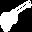

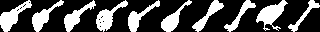

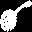

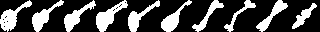

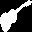

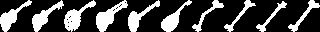

Query 


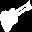

Results


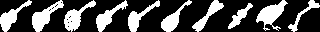

Recall@k: 0.40
Precision@k: 0.60
Query 


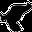

Results


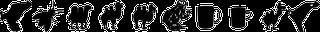

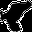

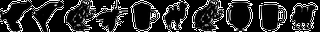

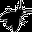

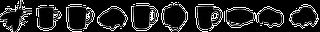

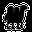

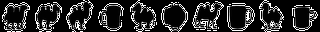

Query 


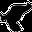

Results


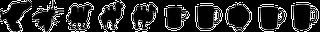

Recall@k: 0.05
Precision@k: 0.10
Query 


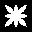

Results


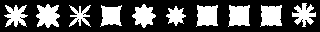

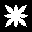

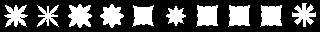

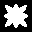

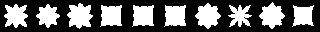

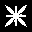

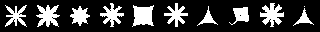

Query 


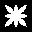

Results


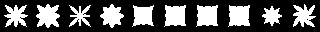

Recall@k: 0.40
Precision@k: 0.60
Query 


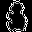

Results


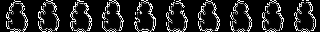

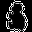

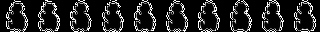

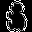

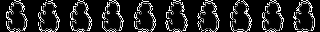

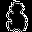

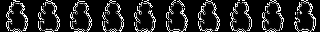

Query 


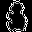

Results


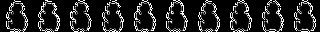

Recall@k: 0.56
Precision@k: 1.00
Query 


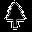

Results


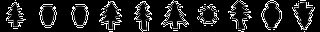

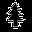

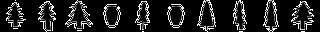

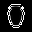

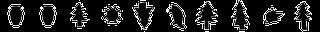

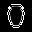

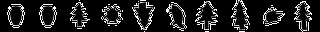

Query 


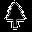

Results


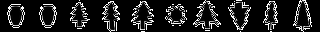

Recall@k: 0.44
Precision@k: 0.70
Query 


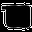

Results


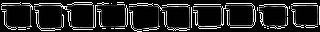

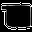

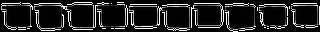

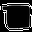

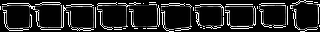

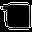

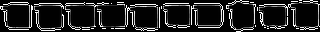

Query 


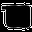

Results


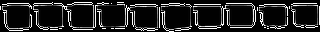

Recall@k: 0.77
Precision@k: 1.00
Query 


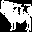

Results


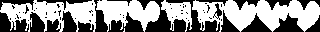

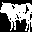

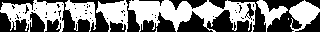

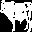

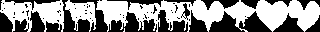

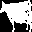

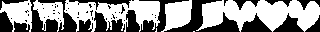

Query 


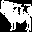

Results


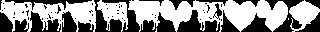

Recall@k: 0.50
Precision@k: 0.60
Query 


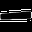

Results


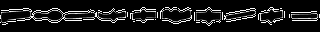

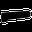

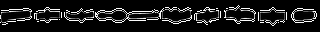

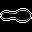

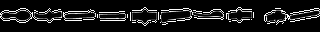

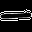

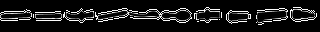

Query 


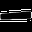

Results


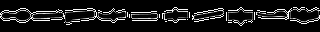

Recall@k: 0.25
Precision@k: 0.40
Query 


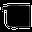

Results


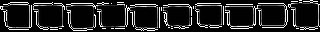

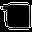

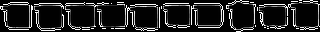

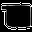

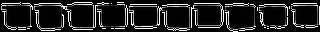

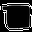

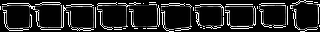

Query 


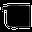

Results


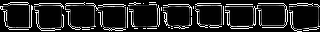

Recall@k: 0.77
Precision@k: 1.00
Query 


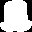

Results


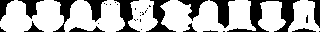

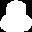

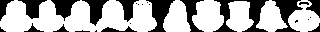

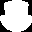

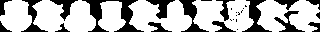

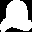

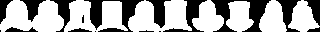

Query 


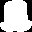

Results


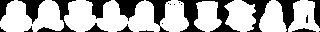

Recall@k: 0.60
Precision@k: 0.90
Query 


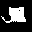

Results


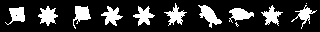

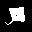

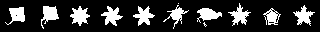

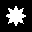

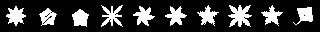

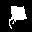

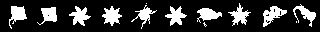

Query 


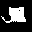

Results


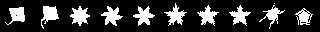

Recall@k: 0.18
Precision@k: 0.20
Query 


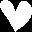

Results


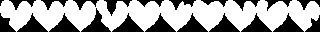

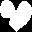

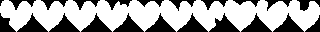

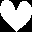

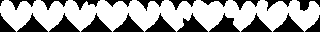

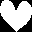

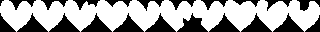

Query 


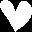

Results


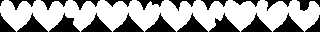

Recall@k: 0.56
Precision@k: 1.00
Query 


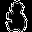

Results


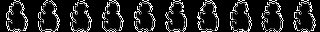

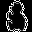

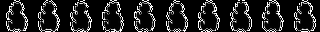

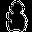

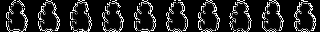

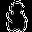

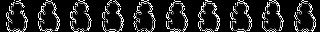

Query 


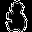

Results


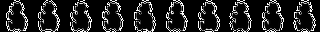

Recall@k: 0.56
Precision@k: 1.00
Query 


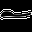

Results


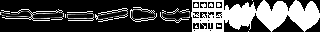

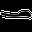

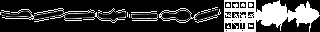

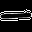

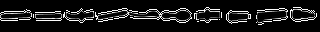

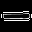

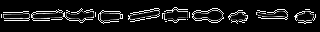

Query 


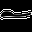

Results


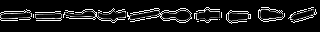

Recall@k: 0.12
Precision@k: 0.20
Query 


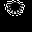

Results


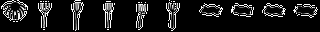

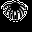

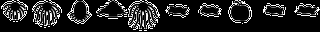

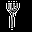

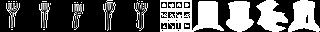

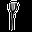

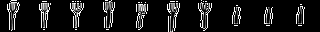

Query 


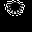

Results


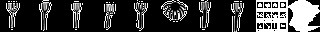

Recall@k: 0.08
Precision@k: 0.10
Query 


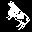

Results


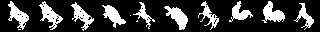

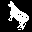

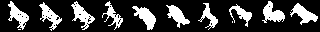

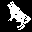

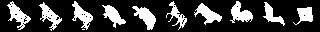

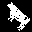

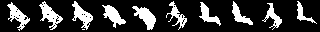

Query 


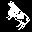

Results


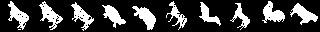

Recall@k: 0.33
Precision@k: 0.40
Query 


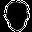

Results


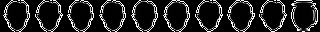

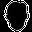

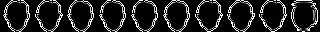

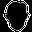

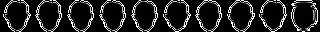

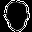

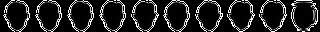

Query 


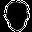

Results


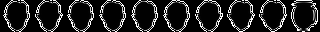

Recall@k: 0.56
Precision@k: 0.90
Query 


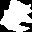

Results


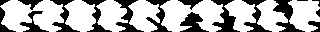

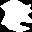

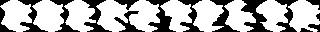

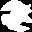

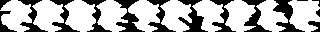

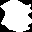

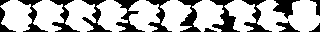

Query 


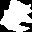

Results


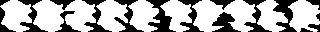

Recall@k: 0.67
Precision@k: 1.00
Query 


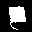

Results


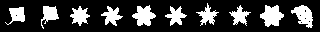

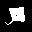

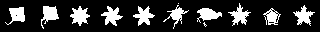

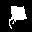

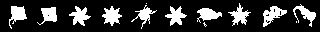

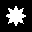

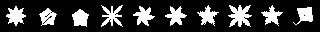

Query 


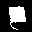

Results


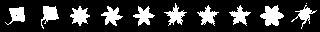

Recall@k: 0.18
Precision@k: 0.20
Query 


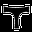

Results


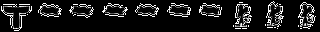

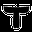

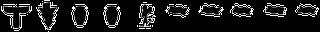

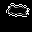

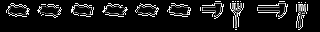

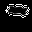

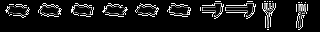

Query 


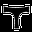

Results


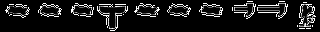

Recall@k: 0.06
Precision@k: 0.10
Query 


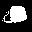

Results


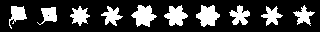

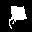

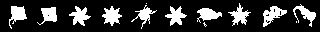

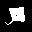

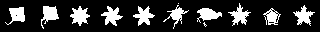

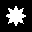

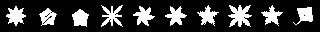

Query 


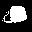

Results


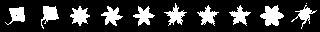

Recall@k: 0.18
Precision@k: 0.20
Query 


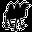

Results


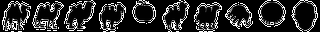

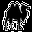

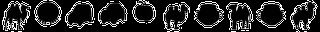

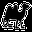

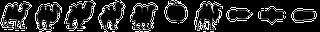

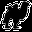

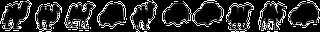

Query 


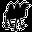

Results


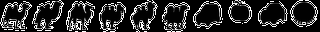

Recall@k: 0.33
Precision@k: 0.60
Query 


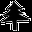

Results


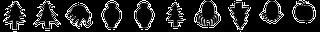

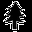

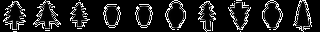

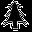

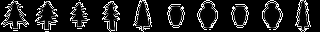

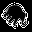

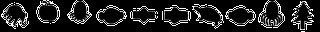

Query 


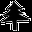

Results


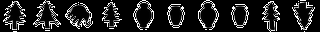

Recall@k: 0.31
Precision@k: 0.50
Query 


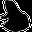

Results


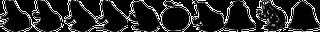

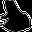

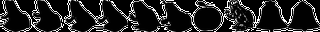

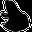

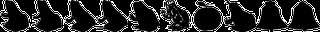

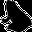

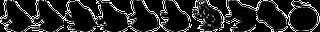

Query 


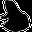

Results


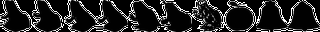

Recall@k: 0.41
Precision@k: 0.70
Query 


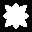

Results


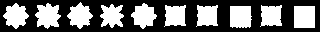

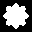

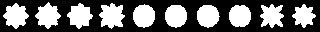

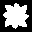

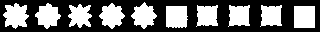

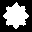

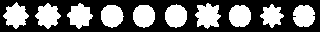

Query 


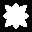

Results


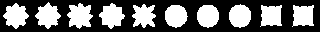

Recall@k: 0.33
Precision@k: 0.50
Query 


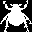

Results


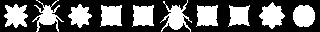

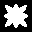

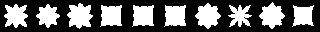

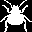

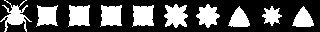

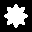

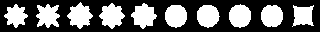

Query 


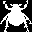

Results


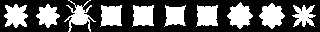

Recall@k: 0.06
Precision@k: 0.10
Query 


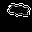

Results


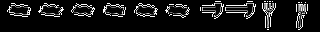

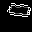

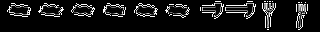

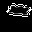

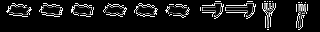

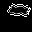

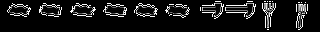

Query 


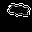

Results


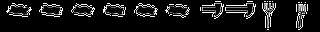

Recall@k: 0.40
Precision@k: 0.60
Query 


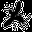

Results


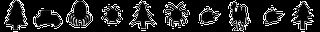

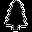

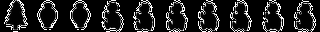

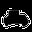

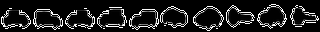

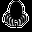

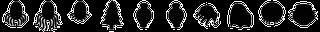

Query 


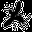

Results


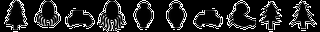

Recall@k: 0.00
Precision@k: 0.00
Query 


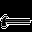

Results


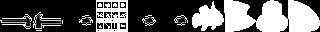

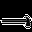

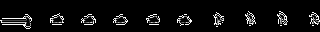

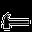

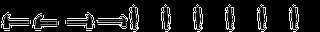

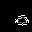

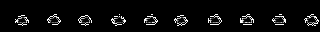

Query 


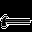

Results


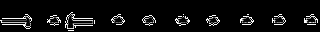

Recall@k: 0.12
Precision@k: 0.20
Query 


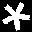

Results


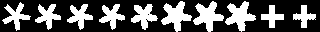

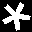

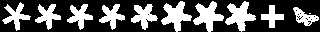

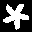

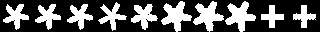

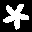

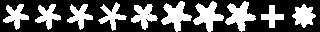

Query 


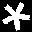

Results


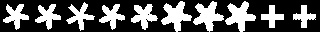

Recall@k: 0.57
Precision@k: 0.80
Query 


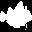

Results


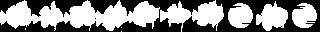

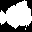

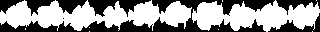

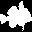

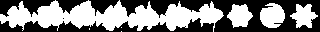

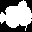

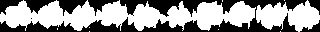

Query 


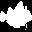

Results


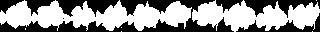

Recall@k: 0.67
Precision@k: 1.00
Query 


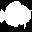

Results


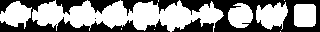

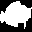

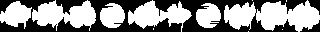

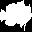

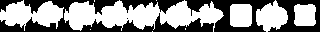

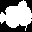

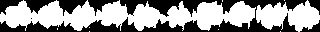

Query 


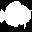

Results


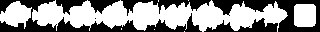

Recall@k: 0.60
Precision@k: 0.90
Query 


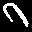

Results


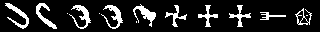

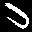

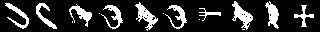

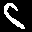

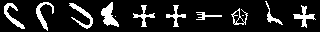

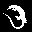

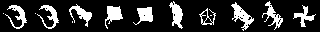

Query 


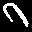

Results


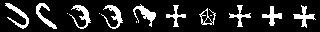

Recall@k: 0.12
Precision@k: 0.20
Query 


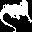

Results


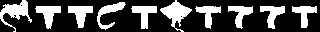

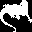

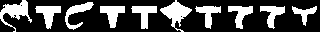

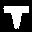

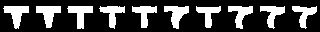

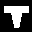

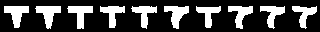

Query 


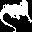

Results


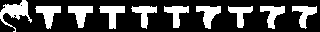

Recall@k: 0.06
Precision@k: 0.10
Query 


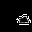

Results


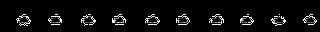

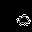

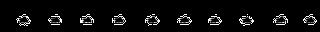

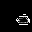

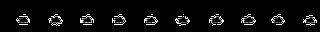

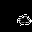

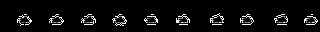

Query 


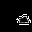

Results


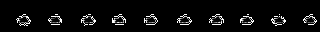

Recall@k: 0.67
Precision@k: 1.00
Query 


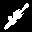

Results


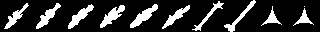

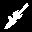

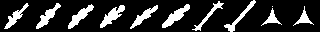

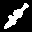

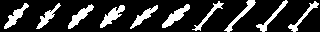

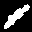

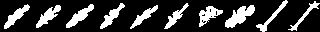

Query 


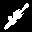

Results


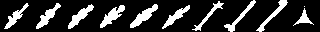

Recall@k: 0.35
Precision@k: 0.60
Query 


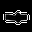

Results


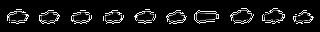

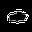

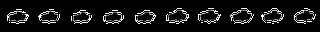

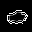

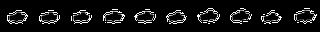

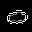

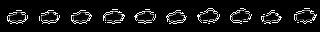

Query 


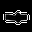

Results


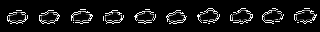

Recall@k: 0.00
Precision@k: 0.00
Query 


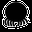

Results


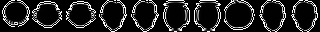

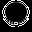

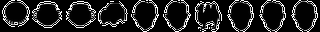

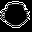

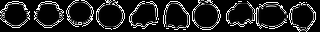

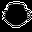

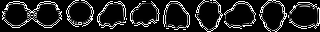

Query 


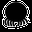

Results


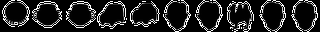

Recall@k: 0.08
Precision@k: 0.10
Query 


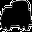

Results


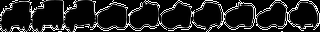

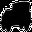

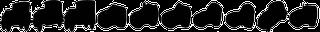

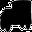

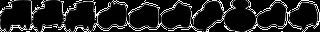

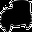

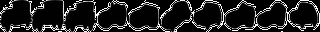

Query 


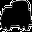

Results


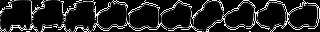

Recall@k: 0.22
Precision@k: 0.40
Query 


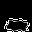

Results


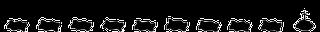

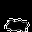

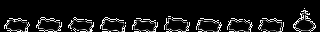

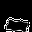

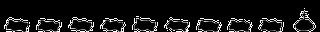

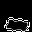

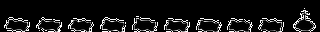

Query 


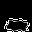

Results


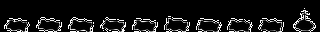

Recall@k: 0.60
Precision@k: 0.90
Query 


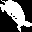

Results


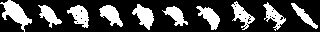

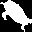

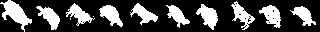

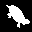

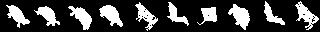

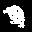

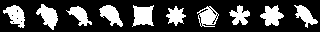

Query 


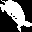

Results


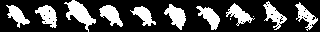

Recall@k: 0.39
Precision@k: 0.70
Query 


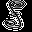

Results


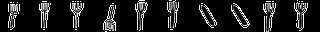

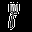

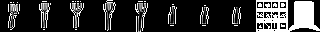

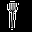

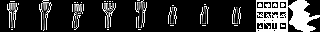

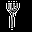

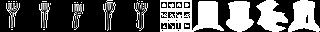

Query 


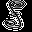

Results


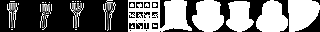

Recall@k: 0.00
Precision@k: 0.00
Query 


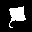

Results


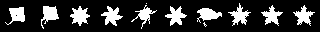

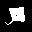

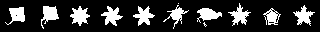

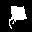

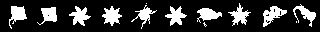

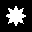

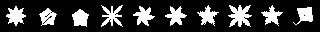

Query 


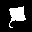

Results


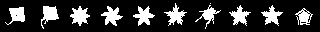

Recall@k: 0.18
Precision@k: 0.20
Query 


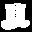

Results


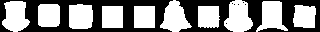

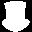

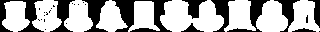

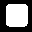

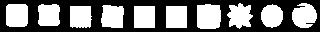

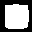

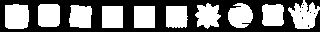

Query 


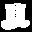

Results


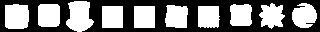

Recall@k: 0.07
Precision@k: 0.10
Query 


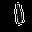

Results


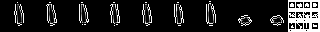

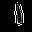

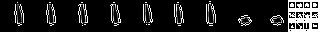

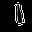

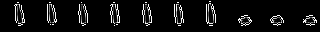

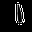

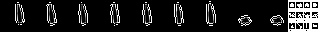

Query 


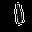

Results


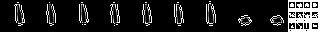

Recall@k: 0.50
Precision@k: 0.70
Query 


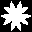

Results


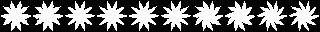

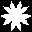

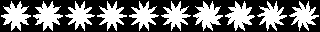

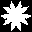

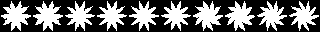

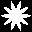

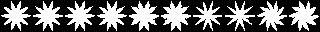

Query 


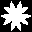

Results


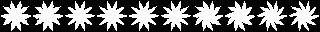

Recall@k: 0.62
Precision@k: 1.00
Query 


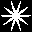

Results


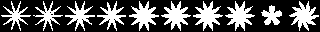

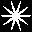

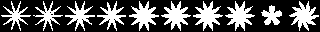

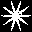

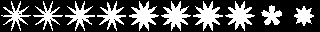

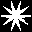

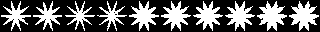

Query 


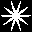

Results


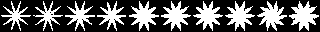

Recall@k: 0.62
Precision@k: 1.00
Query 


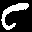

Results


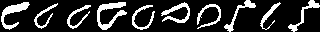

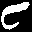

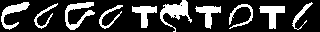

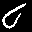

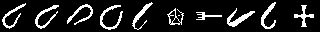

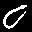

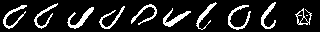

Query 


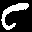

Results


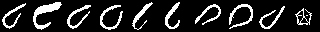

Recall@k: 0.53
Precision@k: 0.90
Query 


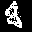

Results


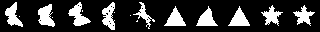

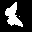

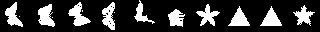

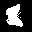

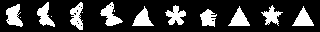

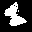

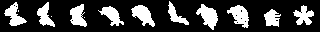

Query 


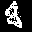

Results


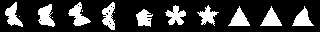

Recall@k: 0.29
Precision@k: 0.40
Query 


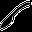

Results


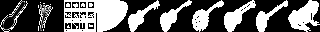

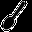

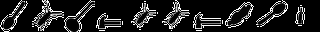

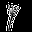

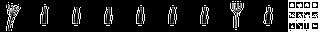

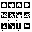

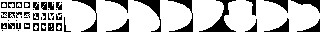

Query 


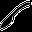

Results


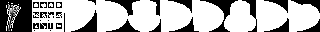

Recall@k: 0.00
Precision@k: 0.00
Query 


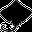

Results


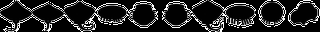

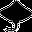

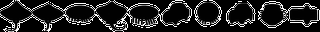

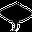

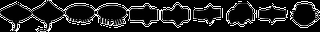

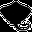

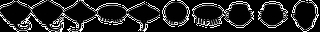

Query 


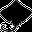

Results


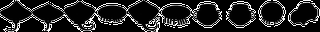

Recall@k: 0.36
Precision@k: 0.40
Query 


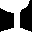

Results


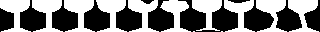

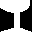

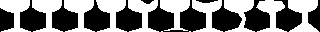

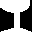

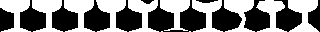

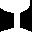

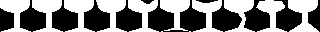

Query 


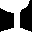

Results


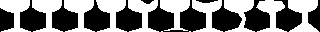

Recall@k: 0.71
Precision@k: 1.00
Query 


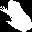

Results


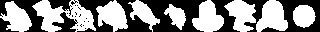

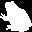

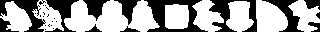

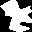

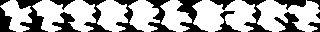

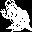

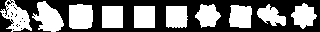

Query 


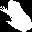

Results


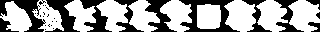

Recall@k: 0.12
Precision@k: 0.20
Query 


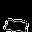

Results


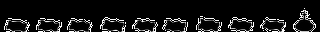

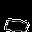

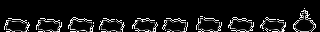

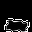

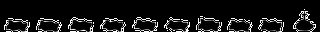

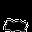

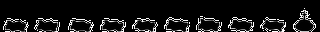

Query 


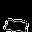

Results


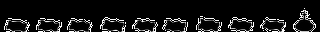

Recall@k: 0.60
Precision@k: 0.90
Query 


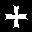

Results


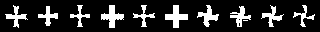

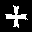

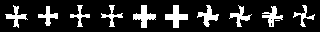

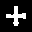

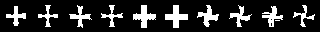

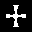

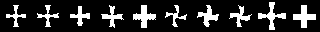

Query 


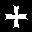

Results


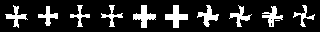

Recall@k: 0.71
Precision@k: 1.00
Query 


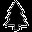

Results


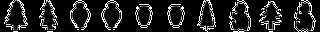

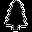

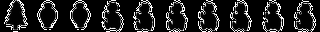

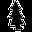

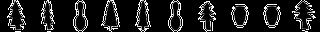

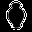

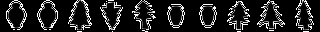

Query 


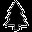

Results


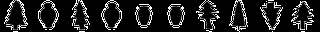

Recall@k: 0.38
Precision@k: 0.60
Query 


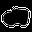

Results


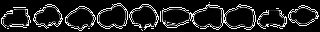

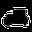

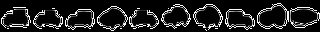

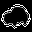

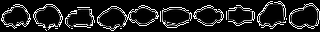

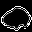

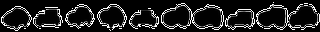

Query 


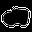

Results


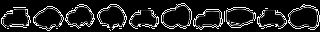

Recall@k: 0.11
Precision@k: 0.20
Query 


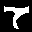

Results


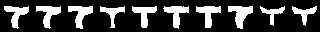

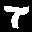

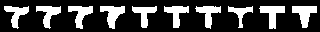

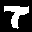

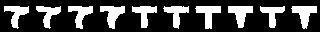

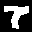

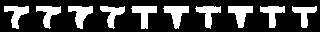

Query 


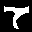

Results


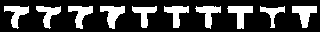

Recall@k: 0.62
Precision@k: 1.00
Query 


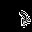

Results


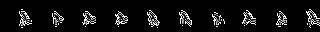

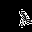

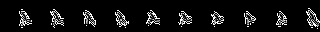

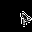

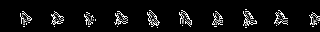

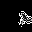

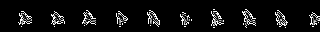

Query 


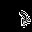

Results


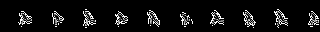

Recall@k: 0.56
Precision@k: 1.00
Query 


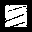

Results


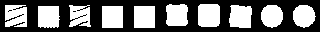

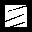

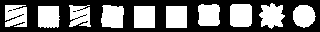

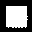

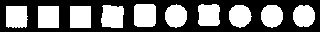

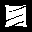

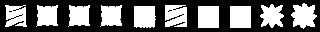

Query 


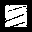

Results


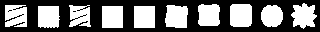

Recall@k: 0.57
Precision@k: 0.80
Query 


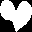

Results


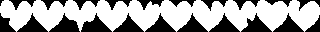

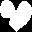

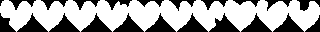

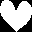

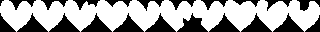

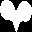

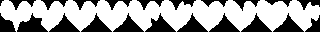

Query 


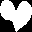

Results


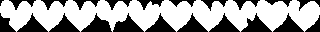

Recall@k: 0.56
Precision@k: 1.00
Query 


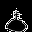

Results


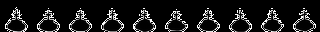

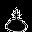

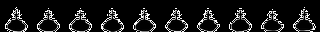

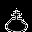

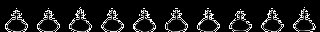

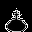

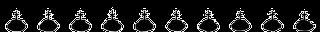

Query 


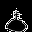

Results


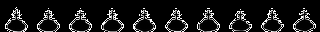

Recall@k: 0.59
Precision@k: 1.00
Query 


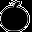

Results


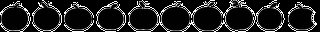

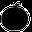

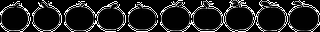

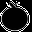

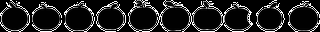

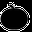

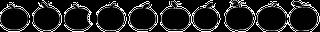

Query 


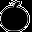

Results


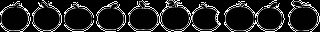

Recall@k: 0.56
Precision@k: 1.00
Query 


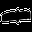

Results


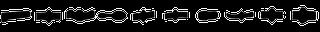

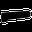

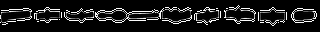

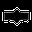

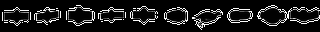

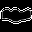

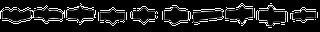

Query 


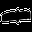

Results


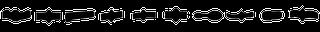

Recall@k: 0.50
Precision@k: 0.70
Query 


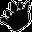

Results


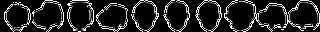

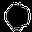

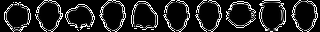

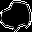

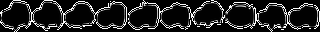

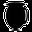

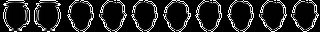

Query 


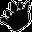

Results


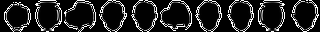

Recall@k: 0.00
Precision@k: 0.00
Query 


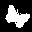

Results


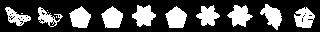

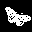

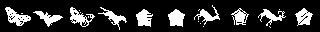

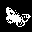

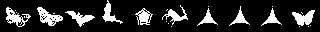

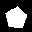

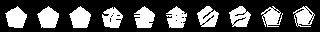

Query 


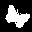

Results


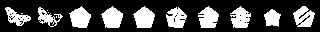

Recall@k: 0.14
Precision@k: 0.20
Query 


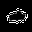

Results


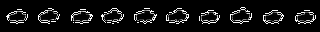

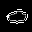

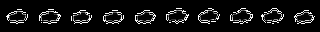

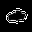

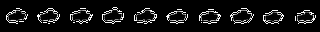

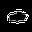

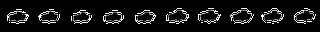

Query 


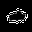

Results


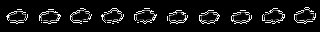

Recall@k: 0.59
Precision@k: 1.00
Query 


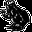

Results


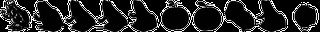

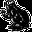

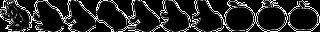

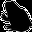

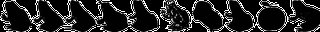

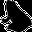

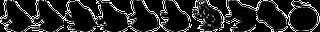

Query 


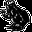

Results


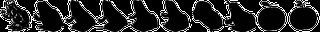

Recall@k: 0.41
Precision@k: 0.70
Query 


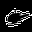

Results


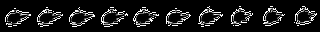

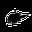

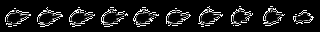

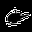

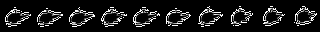

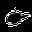

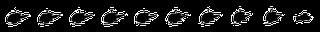

Query 


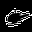

Results


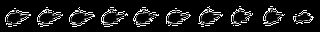

Recall@k: 0.82
Precision@k: 0.90
Query 


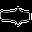

Results


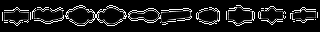

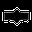

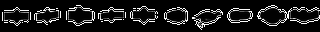

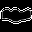

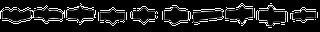

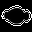

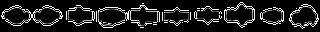

Query 


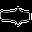

Results


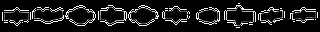

Recall@k: 0.50
Precision@k: 0.70
Query 


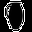

Results


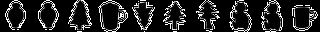

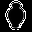

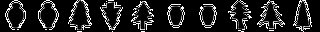

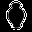

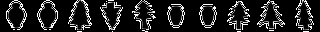

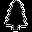

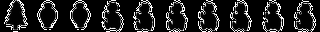

Query 


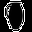

Results


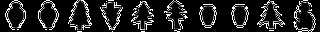

Recall@k: 0.25
Precision@k: 0.40
Query 


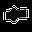

Results


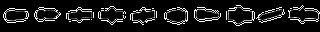

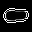

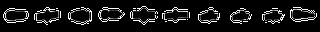

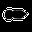

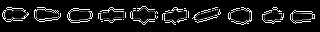

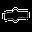

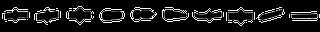

Query 


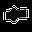

Results


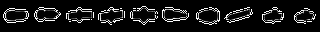

Recall@k: 0.21
Precision@k: 0.30
Query 


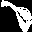

Results


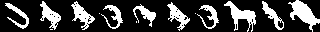

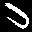

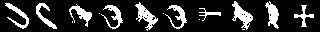

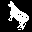

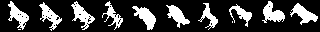

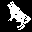

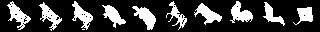

Query 


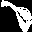

Results


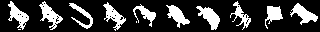

Recall@k: 0.00
Precision@k: 0.00
Query 


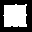

Results


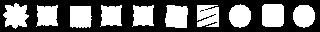

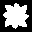

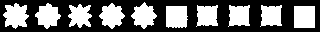

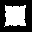

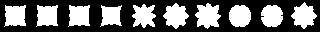

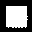

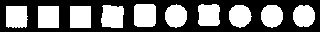

Query 


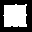

Results


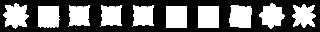

Recall@k: 0.50
Precision@k: 0.70
Query 


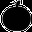

Results


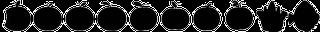

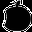

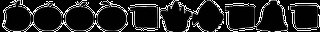

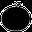

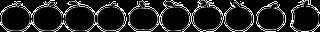

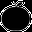

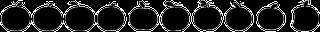

Query 


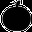

Results


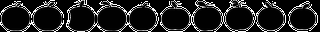

Recall@k: 0.56
Precision@k: 1.00
Query 


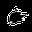

Results


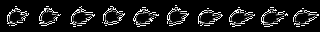

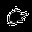

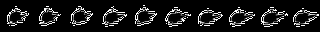

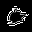

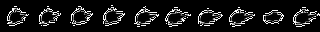

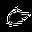

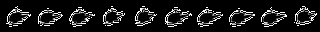

Query 


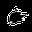

Results


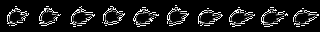

Recall@k: 0.91
Precision@k: 1.00
Query 


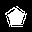

Results


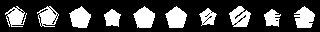

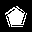

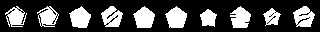

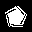

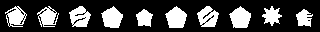

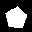

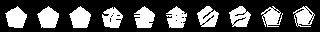

Query 


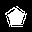

Results


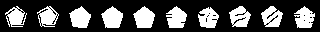

Recall@k: 0.56
Precision@k: 1.00
Query 


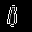

Results


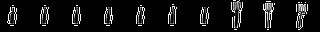

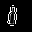

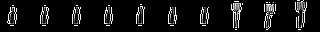

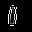

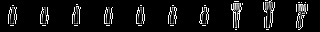

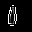

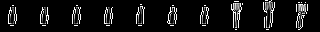

Query 


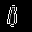

Results


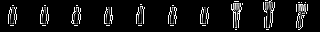

Recall@k: 0.50
Precision@k: 0.70
Query 


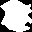

Results


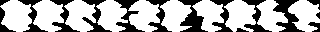

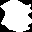

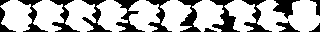

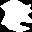

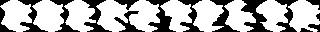

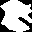

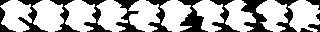

Query 


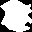

Results


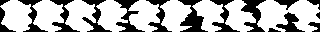

Recall@k: 0.67
Precision@k: 1.00
Query 


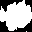

Results


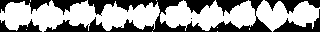

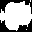

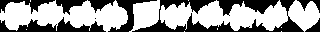

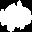

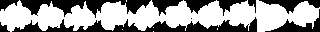

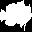

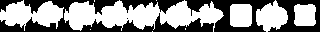

Query 


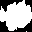

Results


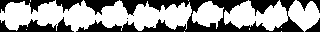

Recall@k: 0.60
Precision@k: 0.90
Query 


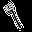

Results


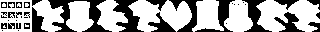

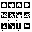

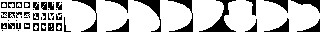

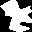

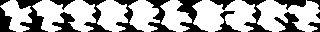

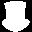

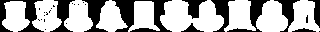

Query 


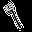

Results


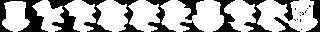

Recall@k: 0.00
Precision@k: 0.00
Query 


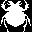

Results


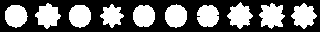

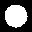

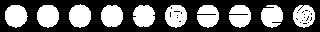

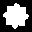

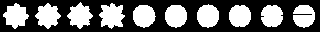

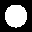

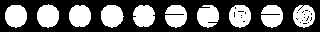

Query 


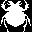

Results


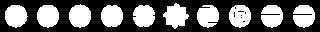

Recall@k: 0.00
Precision@k: 0.00
Query 


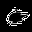

Results


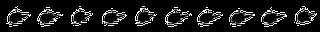

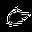

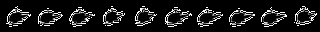

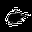

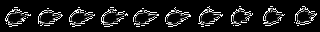

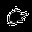

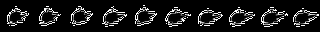

Query 


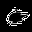

Results


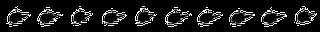

Recall@k: 0.91
Precision@k: 1.00
Query 


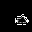

Results


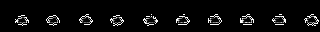

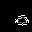

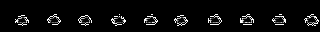

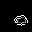

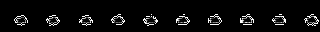

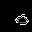

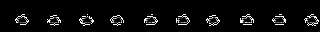

Query 


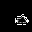

Results


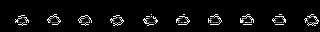

Recall@k: 0.67
Precision@k: 1.00
Query 


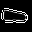

Results


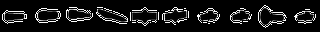

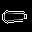

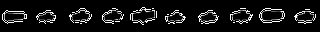

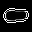

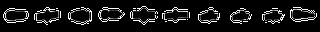

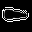

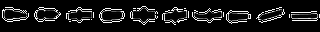

Query 


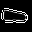

Results


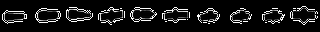

Recall@k: 0.25
Precision@k: 0.40
Query 


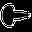

Results


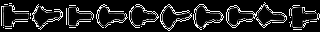

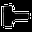

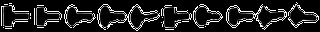

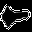

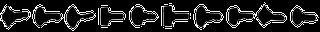

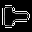

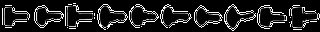

Query 


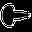

Results


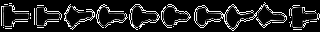

Recall@k: 0.71
Precision@k: 1.00
Query 


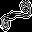

Results


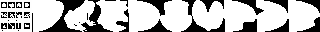

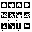

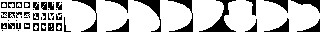

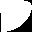

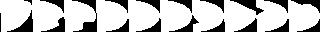

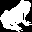

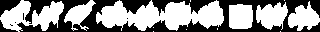

Query 


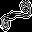

Results


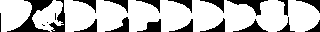

Recall@k: 0.00
Precision@k: 0.00
Query 


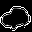

Results


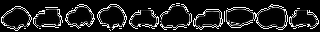

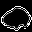

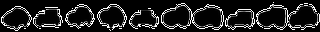

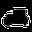

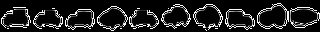

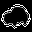

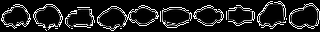

Query 


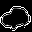

Results


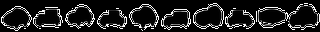

Recall@k: 0.24
Precision@k: 0.40
Query 


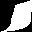

Results


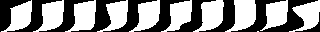

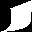

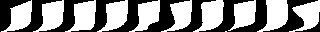

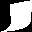

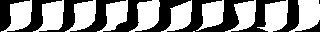

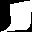

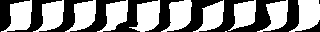

Query 


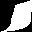

Results


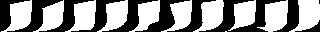

Recall@k: 0.67
Precision@k: 1.00
Query 


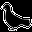

Results


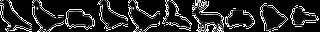

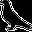

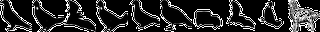

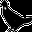

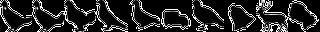

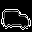

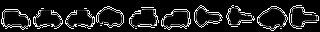

Query 


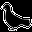

Results


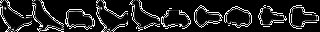

Recall@k: 0.24
Precision@k: 0.40
Query 


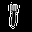

Results


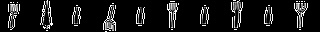

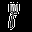

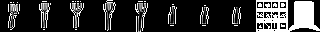

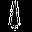

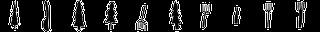

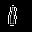

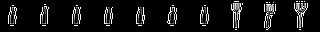

Query 


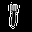

Results


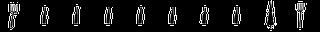

Recall@k: 0.15
Precision@k: 0.20
Query 


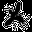

Results


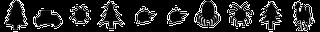

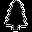

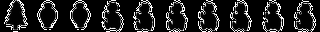

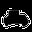

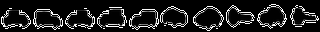

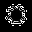

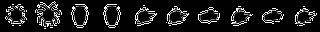

Query 


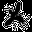

Results


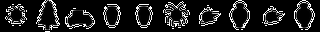

Recall@k: 0.00
Precision@k: 0.00
Query 


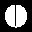

Results


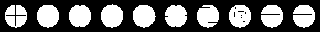

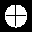

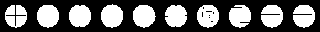

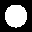

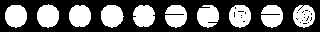

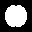

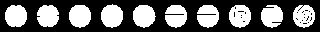

Query 


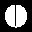

Results


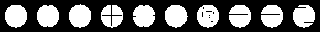

Recall@k: 0.67
Precision@k: 1.00
Query 


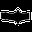

Results


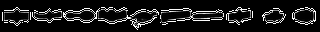

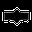

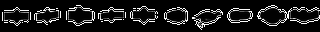

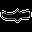

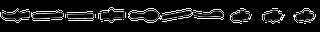

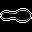

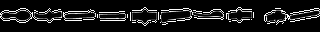

Query 


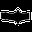

Results


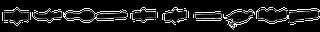

Recall@k: 0.36
Precision@k: 0.50
Query 


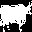

Results


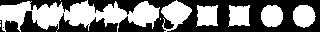

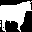

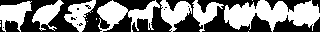

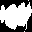

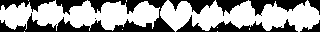

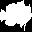

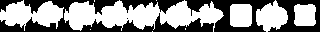

Query 


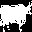

Results


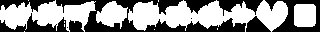

Recall@k: 0.08
Precision@k: 0.10
Query 


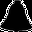

Results


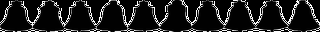

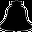

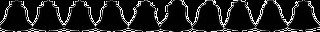

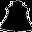

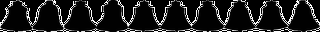

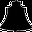

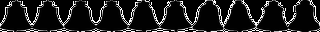

Query 


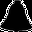

Results


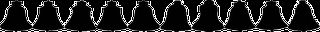

Recall@k: 0.67
Precision@k: 1.00
Query 


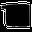

Results


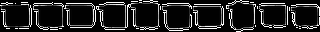

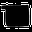

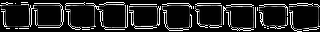

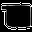

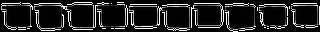

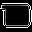

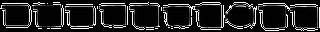

Query 


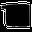

Results


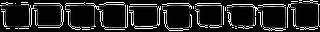

Recall@k: 0.77
Precision@k: 1.00
Query 


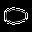

Results


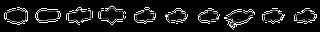

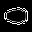

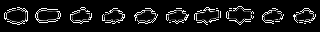

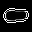

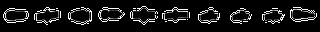

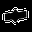

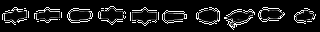

Query 


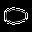

Results


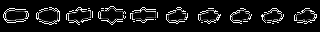

Recall@k: 0.06
Precision@k: 0.10
Query 


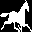

Results


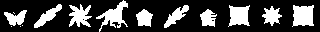

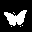

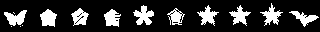

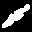

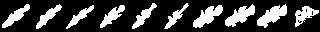

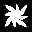

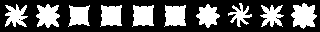

Query 


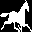

Results


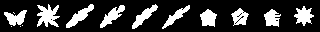

Recall@k: 0.00
Precision@k: 0.00
Query 


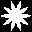

Results


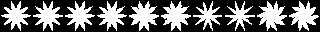

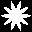

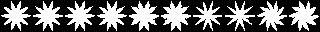

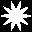

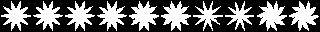

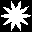

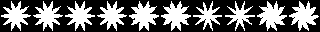

Query 


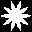

Results


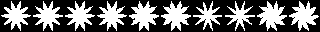

Recall@k: 0.62
Precision@k: 1.00


(0.4243067148131712, 0.6274021352313167)

In [17]:
aqe_precision_and_recall(k=10, m=3, display=True, display_AQE=True)

In [18]:
import pandas as pd
def calculate_average_precision(index, idx, train_names, test_names, label_amounts):
    correct_label = test_names[idx]
    precisions = [] #used for average precision
    found = 0
    k_val = 0
    recall = -1
  
    while (found < label_amounts[correct_label]):
        true_positives = 0
        false_positives = 0
        
        
        for i in range(0,k_val+1):
            if (train_names[index[i]] == correct_label):
                true_positives+=1
                #Will be equal to precision at last correct in image in range
                precision = true_positives/(true_positives + false_positives)
                
            else:
                false_positives+=1
                precision = -1
            
        
        #If Relevant Document found in this iteration add its precision value 
        if (precision != -1):
            precisions.append(precision)
        
        #Check if last value was correct, if so update found
        if (train_names[index[i]] == correct_label):
            found+=1
            
        k_val+=1
    
     #If empty add a zero to array for averaging
    if not precisions:
            precisions.append(0)
    
        
    #Calculate Average Precision
    average_precision = np.average(precisions)
    
    
 
    
    return average_precision

In [19]:
def aqe_mean_average_precision(m=5,start=0, end=len(X_test), display=False, display_AQE=False):
    label_amounts = pd.value_counts(train_names)
    average_precisions = [] 
    
    for test_index in range(start, end):
        #Run original query and store image
        indexes, original_distance = original_query(test_index, k=20)
        original_query_image = X_test[test_index] 
        
        
        #Run additional queries with first m results from original
        index_results, distances = expanded_query(indexes, 20, m, display_AQE)
        
        
        distances.append(original_distance)
        distances = np.array(distances)
        
        #Sum distances for every index on all AQE searches and sort
        total_distances = distances.sum(axis=0)
        
        index = np.argsort(total_distances)
         
        
        #Calculate Precision and Recall @k
        average_precision = calculate_average_precision(index, test_index, train_names, test_names, label_amounts)
        
        if (display):
            #Display final results
            display_images(original_query_image, index[:k], X_train, query_text="Query", result_text="Results", display_query=True) 
            print("Average Precision: {0:.2f} ".format(average_precision))
        
        average_precisions.append(average_precision)
        
    return np.average(average_precisions)
    #OUTPUT
    #mAP for k
    


In [20]:
#Calculate Average Precision per range of k for a given m
def calculate_range_of_k(start, end, m, display=False):
    precisions_at_k = []
    recalls_at_k = []
    
    for k in range(start, end+1):
        recall_at_k, precision_at_k = aqe_precision_and_recall(k, m, display=False)
        
        precisions_at_k.append(precision_at_k)
        recalls_at_k.append(recall_at_k)
        if (display):
            print("\nk = {0}\nmAP = {1:.2f}\nRecall@k = {2:.2f}\nPrecision@k = {3:.2f}".format(k,mAP,recall_at_k,precision_at_k))
    
    return recalls_at_k, precisions_at_k
            
        

In [21]:
from IPython.display import Markdown, display

def display_mAP_range(mAP_for_each_m):
    title = "<h1><left><u>Pixel Value with AQE Baseline: (k={0}-{1})(m=".format(K_START_RANGE, K_END_RANGE)
    for m in range(0,len(M_VALUES)-1):
        title += str(M_VALUES[m]) + ","
    title += str(M_VALUES[m+1]) + ")</left></h1><u>"
    
    display(Markdown(title))
    for mAP, m in zip(mAP_for_each_m, M_VALUES):
        display(Markdown("<h2><left>Mean Average Precision (mAP) for m={0}: {1:.6f}</left></h2>".format(m, mAP)))

In [22]:
precisions_at_k_for_each_m = []
recalls_at_k_for_each_m = []
mAPs_for_each_m = []

for m in M_VALUES:
    mAP = aqe_mean_average_precision(m)
    #Calculate all values of k for given m
    recall_at_m, precision_at_m = calculate_range_of_k(K_START_RANGE, K_END_RANGE, m)
    mAPs_for_each_m.append(mAP)
    recalls_at_k_for_each_m.append(recall_at_m)
    precisions_at_k_for_each_m.append(precision_at_m)

    

In [23]:
display_mAP_range(mAPs_for_each_m)

<h1><left><u>Pixel Value with AQE Baseline: (k=1-20)(m=1,2,3,4,5,6)</left></h1><u>

<h2><left>Mean Average Precision (mAP) for m=1: 0.557568</left></h2>

<h2><left>Mean Average Precision (mAP) for m=2: 0.559621</left></h2>

<h2><left>Mean Average Precision (mAP) for m=3: 0.558213</left></h2>

<h2><left>Mean Average Precision (mAP) for m=4: 0.556806</left></h2>

<h2><left>Mean Average Precision (mAP) for m=5: 0.552275</left></h2>

<h2><left>Mean Average Precision (mAP) for m=6: 0.548770</left></h2>

In [24]:
import plotly.graph_objects as go

k_labels=[]
for i in range(K_START_RANGE, K_END_RANGE+1):
    k_labels.append(i)
    
def precision_recall_table(recalls_at_k, precisions_at_k, m):
    col1 = k_labels + ['<b>Overall<b>']
    col2 = precisions_at_k + ['<b>'+str(np.average(precisions_at_k))+'</b>']
    col3 = recalls_at_k + ['<b>'+str(np.average(recalls_at_k))+'</b>']   

    fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>k</b>','<b>Precision@k</b>', '<b>Recall@k</b>'],
                line_color='darkslategray',
                fill_color='#8aa1b4',
                align='left'),
    cells=dict(values=[col1, col2,col3], 
               line_color='darkslategray',
               fill_color=['#c4cfd9', '#ffffff'],
               align='left'), columnwidth=[150,800])])
    
    fig.update_layout(width=900, height=700, title_text="<b>Precision and Recall for m={0}</b>".format(m), title_x=0.5,title_y=0.91)
    fig.update_layout(title_font=dict(size=20))
    fig.show()

In [25]:
#Change size of cell output to avoid scrolling
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

def plot_precision_recall(recalls_per_k, precisions_per_k, m):
    plt.rcParams["figure.figsize"] = (13,13)
    title = "Pixel Value AQE Baseline (m={0}) (k={1}-{2})".format(m, K_START_RANGE, K_END_RANGE)
    plt.suptitle(title, fontsize=25, y=0.93, fontweight='bold')
    plt.plot(recalls_per_k, precisions_per_k)
    
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xticks([0.2,0.4,0.6,0.8,1.0])
    plt.yticks([0.2,0.4,0.6,0.8,1.0])
   
    plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.savefig('../Graphs/Pixel_Value_AQE_Baseline_M{0}.png'.format(m), facecolor='white')
    plt.show()
    plt.close()

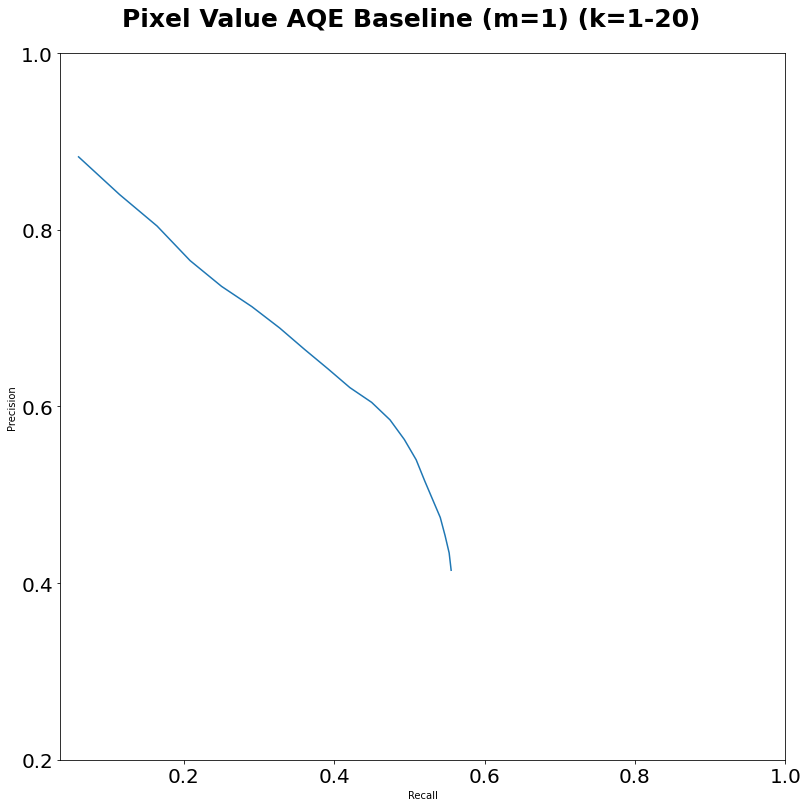

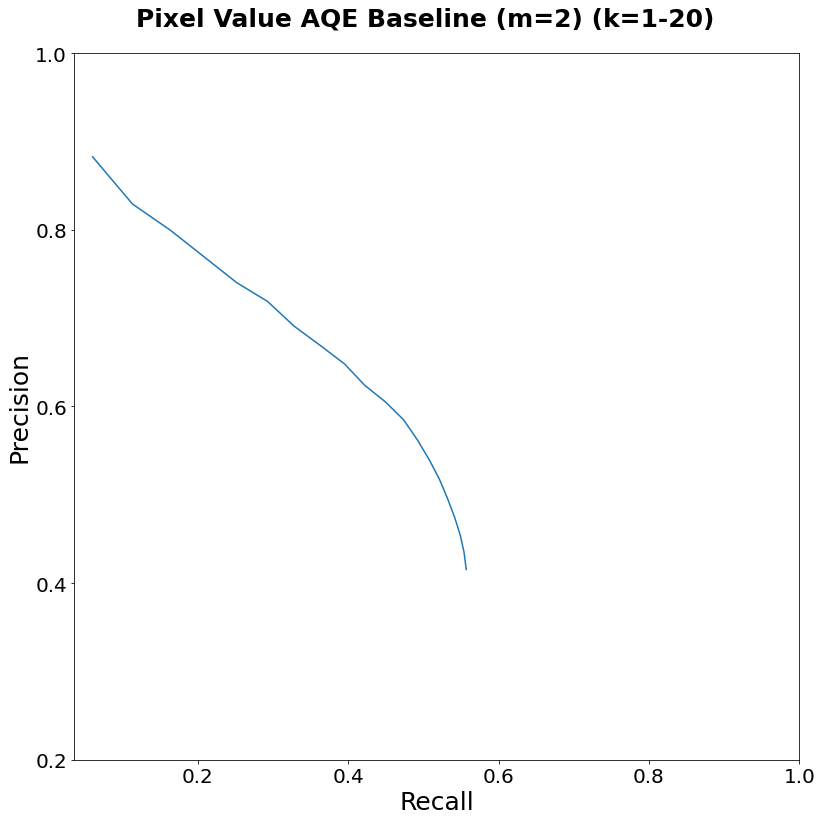

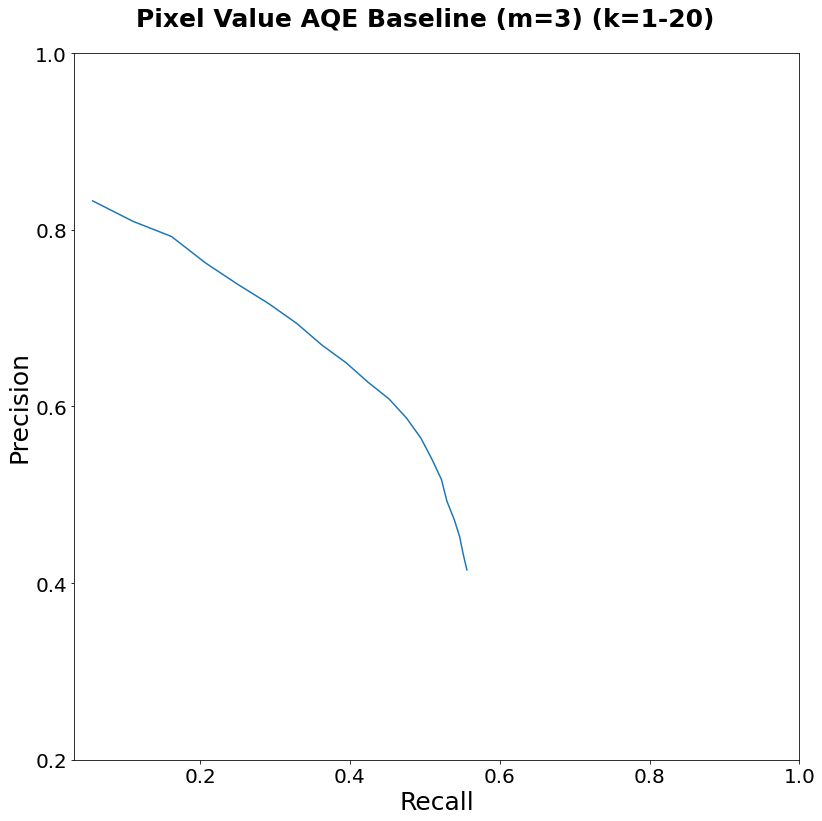

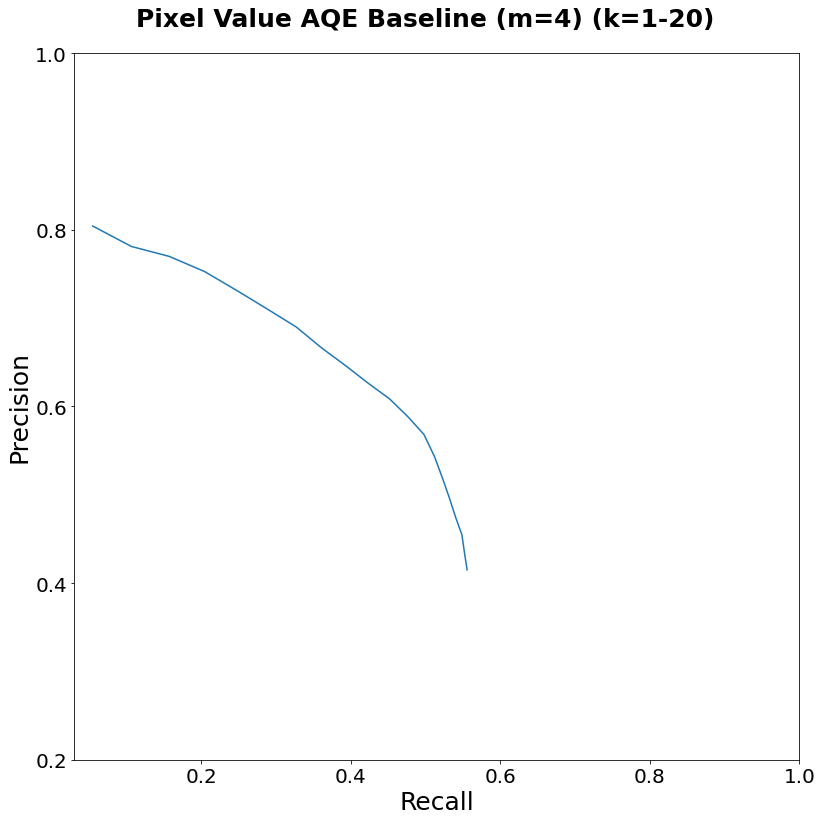

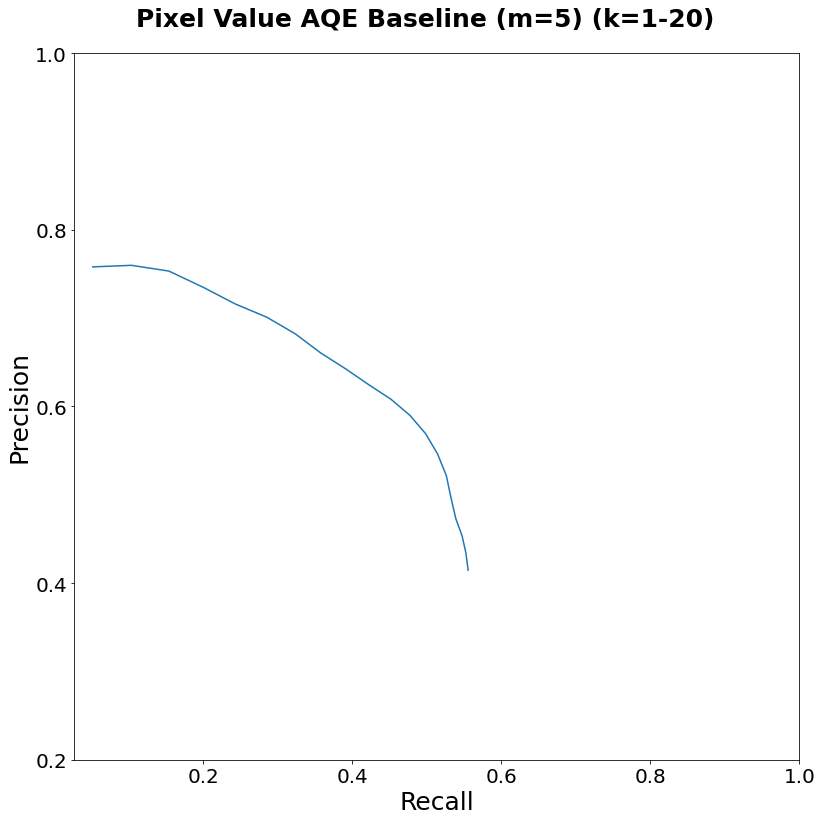

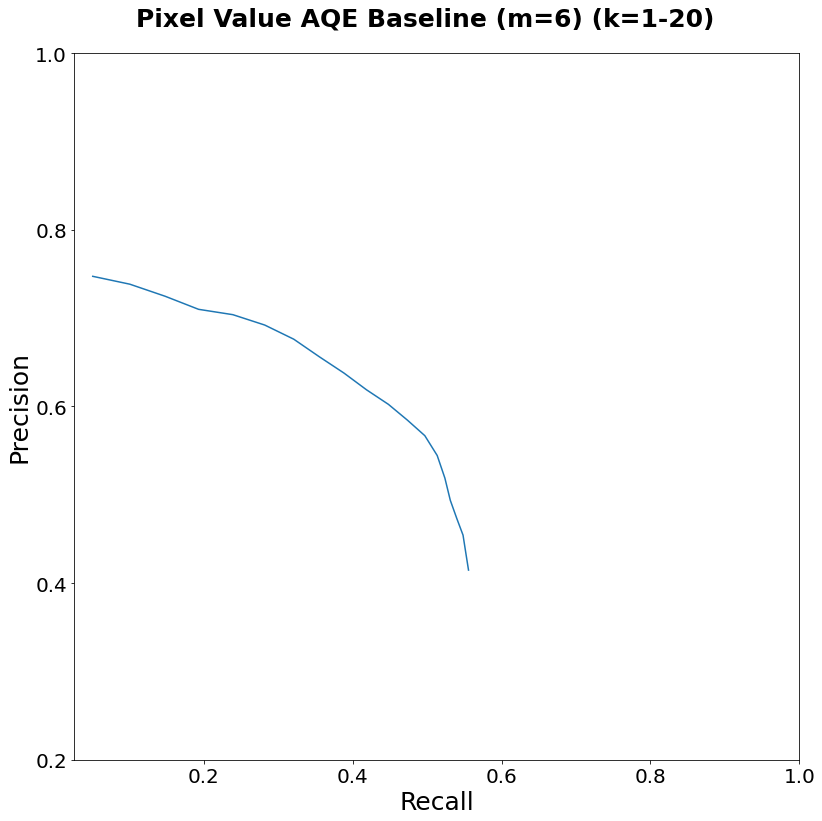

In [26]:
for recall, precision, m in zip(recalls_at_k_for_each_m, precisions_at_k_for_each_m, M_VALUES):
    precision_recall_table(recall, precision, m)
    plot_precision_recall(recall, precision, m)

In [28]:
#rename and store variables
%store M_VALUES
%store precisions_at_k_for_each_m
%store recalls_at_k_for_each_m
%store mAPs_for_each_m

Stored 'M_VALUES' (list)
Stored 'precisions_at_k_for_each_m' (list)
Stored 'recalls_at_k_for_each_m' (list)
Stored 'mAPs_for_each_m' (list)


In [27]:
dill.dump_session("Pixel_Value_With_AQE_Baseline.db")